In [2]:
import os
import scipy.stats as stats
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import squarify


pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 0) 


def calculate_confidence_interval(values, confidence=0.95):
    """
    Calculate confidence interval for a series of values.
    
    Args:
        values: pandas Series or list of values
        confidence: confidence level (default 0.95 for 95% CI)
    
    Returns:
        tuple: (mean, lower_bound, upper_bound, margin_of_error)
    """
    n = len(values)
    mean = np.mean(values)
    std_err = stats.sem(values)  # Standard error of the mean
    
    # Calculate margin of error using t-distribution
    t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
    margin_of_error = t_value * std_err
    
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    
    return mean, lower_bound, upper_bound, margin_of_error


# OVERALL ANSWER SIMILARITY FOR ALL MODELS

def compare_overall_answer_similarity_all_models(folder_path):
    results = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            # Extract similarities
            df = df.dropna(subset=['Answer Semantic Similarity for vanilla', 'Answer Semantic Similarity for rag'])
            vanilla_similarity = df['Answer Semantic Similarity for vanilla'].astype(float).values
            rag_similarity = df['Answer Semantic Similarity for rag'].astype(float).values
            # Calculate confidence intervals
            vanilla_cat_ci = calculate_confidence_interval(vanilla_similarity)
            rag_cat_ci = calculate_confidence_interval(rag_similarity)
            # Paired t-test
            t_stat, p_value = stats.ttest_rel(rag_similarity, vanilla_similarity)
            results.append({
                'Model': filename.replace('.json', ''),
                'Vanilla Mean Similarity': f"{vanilla_cat_ci[0]:.2f}",
                'Vanilla 95% CI': f"[{vanilla_cat_ci[1]:.2f} - {vanilla_cat_ci[2]:.2f}]",
                'RAG Mean Similarity': f'{rag_cat_ci[0]:.2f}',
                'RAG 95% CI': f"[{rag_cat_ci[1]:.2f} - {rag_cat_ci[2]:.2f}]",
                'Difference': f"{(rag_cat_ci[0] - vanilla_cat_ci[0]):.2f}",
                'P Value': p_value,
                'N Vanilla': len(vanilla_similarity),
                'N RAG': len(rag_similarity),
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    # Output results
    drop_cols = ['N Vanilla', 'N RAG']
    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('Model', ascending=True)
        results_df['P Value'] = results_df['P Value'].apply(lambda x: f"{x:.4f}")
        results_df = results_df.drop(columns=[col for col in drop_cols if col in results_df.columns])
        print("Overall Answer Similarity Results:")
        display(results_df.reset_index(drop=True))

        results_df.to_excel(f"{folder_path}/overall_answer_similarity_all_models.xlsx", index=False)


# line plot for answer similarity

def plot_answer_similarity_all_models_line(folder_path, category=None):
    results = []
    
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            if category is not None:
                df = df[df['psychiatric_category'] == category]
            vanilla_similarity = df['Answer Semantic Similarity for vanilla'].astype(float).mean()
            rag_similarity = df['Answer Semantic Similarity for rag'].astype(float).mean()
            results.append({
                'Model': filename.replace('.json', ''),
                'Vanilla Similarity': vanilla_similarity,
                'RAG Similarity': rag_similarity
            })
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    results_df = pd.DataFrame(results)
    results_df.set_index('Model', inplace=True)
    
    short_names = {
    "DeepSeek V3": "DeepSeekV3",
    "Google Gemma 3n E4B-it": "Gemma3B",
    "LG AI ExaOne 3.5 32B Instruct": "Exaone 32B",
    "Meta Llama 3.1 8B Instruct Turbo": "Llama3.1-8B",
    "Meta Llama 4 Maverick 17B-128E-Instruct-FP8": "Llama4-Maverick",
    "Meta Llama 4 Scout 17B-16E Instruct": "Llama4-Scout",
    "Mistral Small 24B Instruct-2501": "Mistral 24B",
    "Qwen 2.5-72B-Instruct-Turbo": "Qwen2.5-72B",
    "Qwen3 235B-A22B-fp8": "Qwen3",
    "Meta Llama 3.2 3B Instruct Turbo": "Llama3.2-3B-Turbo",

    
    
}

    # Replace model names in the DataFrame for plotting
    results_df_plot = results_df.copy()
    results_df_plot['Short Model'] = results_df_plot.index.map(lambda x: short_names.get(x, x))

    title = f'Answer Similarity Scores for All Models'

    plt.figure(figsize=(10, 6))
    plt.plot(results_df_plot['Short Model'], results_df_plot['Vanilla Similarity'], marker='o', label='Vanilla Similarity')
    plt.plot(results_df_plot['Short Model'], results_df_plot['RAG Similarity'], marker='o', label='RAG Similarity')
    if category:
        title += f" ({category})"
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel('Similarity Score')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()



# BAR CHART FOR ANSWER SIMILARITY

def plot_answer_similarity_all_models_bar_chart(folder_path, category=None):
    results = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            if category is not None:
                df = df[df['psychiatric_category'] == category]
            vanilla_similarity = df['Answer Semantic Similarity for vanilla'].astype(float).mean()
            rag_similarity = df['Answer Semantic Similarity for rag'].astype(float).mean()
            results.append({
                'Model': filename.replace('.json', ''),
                'Vanilla Similarity': vanilla_similarity,
                'RAG Similarity': rag_similarity
            })
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    results_df = pd.DataFrame(results)
    results_df.set_index('Model', inplace=True)

    short_names = {
        "DeepSeek V3": "DeepSeekV3",
        "Google Gemma 3n E4B-it": "Gemma3B",
        "LG AI ExaOne 3.5 32B Instruct": "Exaone 32B",
        "Meta Llama 3.1 8B Instruct Turbo": "Llama3.1-8B",
        "Meta Llama 4 Maverick 17B-128E-Instruct-FP8": "Llama4-Maverick",
        "Meta Llama 4 Scout 17B-16E Instruct": "Llama4-Scout",
        "Mistral Small 24B Instruct-2501": "Mistral 24B",
        "Qwen 2.5-72B-Instruct-Turbo": "Qwen2.5-72B",
        "Qwen3 235B-A22B-fp8": "Qwen3",
        "Meta Llama 3.2 3B Instruct Turbo": "Llama3.2-3B-Turbo",
    }

    results_df['Short Model'] = results_df.index.map(lambda x: short_names.get(x, x))
    results_df = results_df.sort_values('Vanilla Similarity', ascending=False)

    # Bar chart
    import numpy as np
    import matplotlib.pyplot as plt

    x = np.arange(len(results_df))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, results_df['Vanilla Similarity'], width, label='Vanilla Similarity')
    ax.bar(x + width/2, results_df['RAG Similarity'], width, label='RAG Similarity')

    ax.set_xticks(x)
    ax.set_xticklabels(results_df['Short Model'], rotation=45)
    ax.set_ylabel('Similarity Score')
   # ax.set_ylim(bottom=0.82)
    title = 'Answer Similarity Scores for All Models (Bar Chart)'
    if category:
        title += f" ({category})"
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()


categories_full = ['Depressive Disorders',
            'Somatic Disorders', 
            'Anxiety Disorders',
            'Other Mental Disorders',
            'Bipolar Disorders',
            'Schizophrenia Spectrum and Other Psychotic Disorders',
            'Trauma and Stressor Related Disorders',
            'Personality Disorders',
            'Obsessive-Compulsive Disorders',
            'Eating Disorders',
            'Dissociative Disorders']  

categories = ['Depressive Disorders'
            ]  

# Answer similarity by category

def compare_similarity_by_category(folder_path, categories):

    for category in categories:
        results = []
        for filename in os.listdir(folder_path):
            if not filename.endswith('.json'):
                continue
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                df = pd.DataFrame(data)
                df = df[df['psychiatric_category'] == category]
                df = df.dropna(subset=['Answer Semantic Similarity for vanilla', 'Answer Semantic Similarity for rag'])
                # Extract similarities
                vanilla_similarity = df['Answer Semantic Similarity for vanilla'].astype(float).values
                rag_similarity = df['Answer Semantic Similarity for rag'].astype(float).values
                # Calculate confidence intervals
                if len(vanilla_similarity) > 1 and len(rag_similarity) > 1 and len(vanilla_similarity) == len(rag_similarity):
                    vanilla_cat_ci = calculate_confidence_interval(vanilla_similarity)
                    rag_cat_ci = calculate_confidence_interval(rag_similarity)
                    # Paired t-test
                    t_stat, p_value = stats.ttest_rel(rag_similarity, vanilla_similarity)
                    results.append({
                        'Model': filename.replace('.json', ''),
                        'Vanilla Mean Similarity': vanilla_cat_ci[0],
                        'Vanilla 95% CI': f"[{vanilla_cat_ci[1]:.4f} - {vanilla_cat_ci[2]:.4f}]",
                        'RAG Mean Similarity': rag_cat_ci[0],
                        'RAG 95% CI': f"[{rag_cat_ci[1]:.4f} - {rag_cat_ci[2]:.4f}]",
                        'Difference': rag_cat_ci[0] - vanilla_cat_ci[0],
                        'P Value': p_value,
                        'N Vanilla': len(vanilla_similarity),
                        'N RAG': len(rag_similarity),
                        'Significant': 'Yes' if p_value < 0.05 else 'No'
                    })
                else:
                    print(f"Insufficient data for category '{category}' in file {filename}. Skipping.")
            except Exception as e:
                print(f"Failed to process {filename}: {e}")

        # Output results
        drop_cols = ['N Vanilla', 'N RAG']
        if results:
            results_df = pd.DataFrame(results)
            results_df = results_df.sort_values('Difference', ascending=False)
            results_df['P Value'] = results_df['P Value'].apply(lambda x: f"{x:.4f}")
            results_df = results_df.drop(columns=[col for col in drop_cols if col in results_df.columns])
            print(f"Answer Similarity Results for Category: {category}")
            display(results_df.reset_index(drop=True))
    

In [3]:

# ANSWER RELEVANCY FOR ALL MODELS
def compare_overall_answer_relevancy_all_models(folder_path):
    results = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            # Calculate mean answer relevancy for vanilla and RAG
            vanilla_cols = [
                "answer_relevancy for Vanilla run 1",
                "answer_relevancy for Vanilla run 2",
                "answer_relevancy for Vanilla run 3"
            ]
            rag_cols = [
                "answer_relevancy for RAG run 1",
                "answer_relevancy for RAG run 2",
                "answer_relevancy for RAG run 3"
            ]
            for col in vanilla_cols:
                if col not in df.columns:
                    df[col] = np.nan
            for col in rag_cols:
                if col not in df.columns:
                    df[col] = np.nan
            df["Mean answer_relevancy for Vanilla"] = df[vanilla_cols].astype(float).mean(axis=1, skipna=True)
            df["Mean answer_relevancy for RAG"] = df[rag_cols].astype(float).mean(axis=1, skipna=True)
            # Drop rows with missing means
            df = df.dropna(subset=["Mean answer_relevancy for Vanilla", "Mean answer_relevancy for RAG"])
            vanilla_relevancy = df["Mean answer_relevancy for Vanilla"].values
            rag_relevancy = df["Mean answer_relevancy for RAG"].values
            # Calculate confidence intervals
            vanilla_ci = calculate_confidence_interval(vanilla_relevancy)
            rag_ci = calculate_confidence_interval(rag_relevancy)
            # Paired t-test
            t_stat, p_value = stats.ttest_rel(rag_relevancy, vanilla_relevancy)
            results.append({
                'Model': filename.replace('.json', ''),
                'Vanilla Mean Relevancy': f'{vanilla_ci[0]:.2f}',
                'Vanilla 95% CI': f"[{vanilla_ci[1]:.2f} - {vanilla_ci[2]:.2f}]",
                'RAG Mean Relevancy': f"{rag_ci[0]:.2f}",
                'RAG 95% CI': f"[{rag_ci[1]:.2f} - {rag_ci[2]:.2f}]",
                'Difference': f'{(rag_ci[0] - vanilla_ci[0]):.2f}',
                'P Value': p_value,
                'N Vanilla': len(vanilla_relevancy),
                'N RAG': len(rag_relevancy),
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    # Output results
    drop_cols = ['N Vanilla', 'N RAG']
    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('Model', ascending=True)
        results_df['P Value'] = results_df['P Value'].apply(lambda x: f"{x:.4f}")
        results_df = results_df.drop(columns=[col for col in drop_cols if col in results_df.columns])
        print("Overall Answer Relevancy Results:")
        display(results_df.reset_index(drop=True))
        results_df.to_excel(f"{folder_path}/overall_answer_relevancy_all_models.xlsx", index=False)



# line plot for answer relevancy

def plot_answer_relevancy_all_models_line(folder_path, category=None):
    results = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            # Prepare columns for relevancy
            vanilla_cols = [
                "answer_relevancy for Vanilla run 1",
                "answer_relevancy for Vanilla run 2",
                "answer_relevancy for Vanilla run 3"
            ]
            rag_cols = [
                "answer_relevancy for RAG run 1",
                "answer_relevancy for RAG run 2",
                "answer_relevancy for RAG run 3"
            ]
            for col in vanilla_cols:
                if col not in df.columns:
                    df[col] = np.nan
            for col in rag_cols:
                if col not in df.columns:
                    df[col] = np.nan
            df["Mean answer_relevancy for Vanilla"] = df[vanilla_cols].astype(float).mean(axis=1, skipna=True)
            df["Mean answer_relevancy for RAG"] = df[rag_cols].astype(float).mean(axis=1, skipna=True)
            if category is not None:
                df = df[df['psychiatric_category'] == category]
            if df.empty:
                continue
            vanilla_relevancy = df["Mean answer_relevancy for Vanilla"].mean()
            rag_relevancy = df["Mean answer_relevancy for RAG"].mean()
            results.append({
                'Model': filename.replace('.json', ''),
                'LLM Relevancy': vanilla_relevancy,
                'RAG Relevancy': rag_relevancy
            })
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    if not results:
        print(f"No data found for category: {category}")
        return

    results_df = pd.DataFrame(results)
    results_df.set_index('Model', inplace=True)

    short_names = {
        "DeepSeek V3": "DeepSeekV3",
        "Google Gemma 3n E4B-it": "Gemma3B",
        "LG AI ExaOne 3.5 32B Instruct": "Exaone 32B",
        "Meta Llama 3.1 8B Instruct Turbo": "Llama3.1-8B",
        "Meta Llama 4 Maverick 17B-128E-Instruct-FP8": "Llama4-Maverick",
        "Meta Llama 4 Scout 17B-16E Instruct": "Llama4-Scout",
        "Mistral Small 24B Instruct-2501": "Mistral 24B",
        "Qwen 2.5-72B-Instruct-Turbo": "Qwen2.5-72B",
        "Qwen3 235B-A22B-fp8": "Qwen3",
        "Meta Llama 3.1 8B Instruct Turbo": "Llama3.1-8B-Turbo"
    }

    results_df_plot = results_df.copy()
    results_df_plot['Short Model'] = results_df_plot.index.map(lambda x: short_names.get(x, x))

    plt.figure(figsize=(10, 6))
    plt.plot(results_df_plot['Short Model'], results_df_plot['Vanilla Relevancy'], marker='o', label='LLM Relevancy')
    plt.plot(results_df_plot['Short Model'], results_df_plot['RAG Relevancy'], marker='o', label='RAG Relevancy')
    title = "Answer Relevancy Scores for All Models"
    if category:
        title += f" ({category})"
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel('Relevancy Score')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()





# compare answer relevancy by category
def compare_relevancy_by_category(folder_path, categories):
    for category in categories:
        results = []
        for filename in os.listdir(folder_path):
            if not filename.endswith('.json'):
                continue
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                df = pd.DataFrame(data)
                df = df[df['psychiatric_category'] == category]
                vanilla_cols = [
                    "answer_relevancy for Vanilla run 1",
                    "answer_relevancy for Vanilla run 2",
                    "answer_relevancy for Vanilla run 3"
                ]
                rag_cols = [
                    "answer_relevancy for RAG run 1",
                    "answer_relevancy for RAG run 2",
                    "answer_relevancy for RAG run 3"
                ]
                for col in vanilla_cols:
                    if col not in df.columns:
                        df[col] = np.nan
                for col in rag_cols:
                    if col not in df.columns:
                        df[col] = np.nan
                df["Mean answer_relevancy for Vanilla"] = df[vanilla_cols].astype(float).mean(axis=1, skipna=True)
                df["Mean answer_relevancy for RAG"] = df[rag_cols].astype(float).mean(axis=1, skipna=True)
                df = df.dropna(subset=["Mean answer_relevancy for Vanilla", "Mean answer_relevancy for RAG"])
                vanilla_relevancy = df["Mean answer_relevancy for Vanilla"].values
                rag_relevancy = df["Mean answer_relevancy for RAG"].values
                if len(vanilla_relevancy) > 1 and len(rag_relevancy) > 1 and len(vanilla_relevancy) == len(rag_relevancy):
                    vanilla_ci = calculate_confidence_interval(vanilla_relevancy)
                    rag_ci = calculate_confidence_interval(rag_relevancy)
                    t_stat, p_value = stats.ttest_rel(rag_relevancy, vanilla_relevancy)
                    results.append({
                        'Model': filename.replace('.json', ''),
                        'Vanilla Mean Relevancy': vanilla_ci[0],
                        'Vanilla 95% CI': f"[{vanilla_ci[1]:.2f} - {vanilla_ci[2]:.2f}]",
                        'RAG Mean Relevancy': rag_ci[0],
                        'RAG 95% CI': f"[{rag_ci[1]:.2f} - {rag_ci[2]:.2f}]",
                        'Difference': rag_ci[0] - vanilla_ci[0],
                        'P Value': p_value,
                        'N Vanilla': len(vanilla_relevancy),
                        'N RAG': len(rag_relevancy),
                        'Significant': 'Yes' if p_value < 0.05 else 'No'
                    })
                else:
                    print(f"Insufficient data for category '{category}' in file {filename}. Skipping.")
            except Exception as e:
                print(f"Failed to process {filename}: {e}")

        drop_cols = ['N Vanilla', 'N RAG']
        if results:
            results_df = pd.DataFrame(results)
            results_df = results_df.sort_values('Difference', ascending=False)
            results_df['P Value'] = results_df['P Value'].apply(lambda x: f"{x:.4f}")
            results_df = results_df.drop(columns=[col for col in drop_cols if col in results_df.columns])
            print(f"Answer Relevancy Results for Category: {category}")
            display(results_df.reset_index(drop=True))



# bar chart for answer relevancy

def plot_answer_relevancy_all_models_bar_chart(folder_path, category=None):
    results = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            # Prepare columns for relevancy
            vanilla_cols = [
                "answer_relevancy for Vanilla run 1",
                "answer_relevancy for Vanilla run 2",
                "answer_relevancy for Vanilla run 3"
            ]
            rag_cols = [
                "answer_relevancy for RAG run 1",
                "answer_relevancy for RAG run 2",
                "answer_relevancy for RAG run 3"
            ]
            for col in vanilla_cols:
                if col not in df.columns:
                    df[col] = np.nan
            for col in rag_cols:
                if col not in df.columns:
                    df[col] = np.nan
            df["Mean answer_relevancy for Vanilla"] = df[vanilla_cols].astype(float).mean(axis=1, skipna=True)
            df["Mean answer_relevancy for RAG"] = df[rag_cols].astype(float).mean(axis=1, skipna=True)
            if category is not None:
                df = df[df['psychiatric_category'] == category]
            vanilla_relevancy = df["Mean answer_relevancy for Vanilla"].mean()
            rag_relevancy = df["Mean answer_relevancy for RAG"].mean()
            results.append({
                'Model': filename.replace('.json', ''),
                'Vanilla Relevancy': vanilla_relevancy,
                'RAG Relevancy': rag_relevancy
            })
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    results_df = pd.DataFrame(results)
    results_df.set_index('Model', inplace=True)

    short_names = {
        "DeepSeek V3": "DeepSeekV3",
        "Google Gemma 3n E4B-it": "Gemma3B",
        "LG AI ExaOne 3.5 32B Instruct": "Exaone 32B",
        "Meta Llama 3.1 8B Instruct Turbo": "Llama3.1-8B",
        "Meta Llama 4 Maverick 17B-128E-Instruct-FP8": "Llama4-Maverick",
        "Meta Llama 4 Scout 17B-16E Instruct": "Llama4-Scout",
        "Mistral Small 24B Instruct-2501": "Mistral 24B",
        "Qwen 2.5-72B-Instruct-Turbo": "Qwen2.5-72B",
        "Qwen3 235B-A22B-fp8": "Qwen3",
        "Meta Llama 3.2 3B Instruct Turbo": "Llama3.2-3B-Turbo",
    }

    results_df['Short Model'] = results_df.index.map(lambda x: short_names.get(x, x))
    results_df = results_df.sort_values('Model', ascending=True)

    # Bar chart
    import numpy as np
    import matplotlib.pyplot as plt

    x = np.arange(len(results_df))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, results_df['Vanilla Relevancy'], width, label='LLM Relevancy')
    ax.bar(x + width/2, results_df['RAG Relevancy'], width, label='RAG Relevancy')

    ax.set_xticks(x)
    ax.set_xticklabels(results_df['Short Model'], rotation=45)
    ax.set_ylabel('Relevancy Score')
    ax.set_ylim(bottom=0.30)
    title = 'Answer Relevancy Scores for All Models (Bar Chart)'
    if category:
        title += f" ({category})"
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [4]:
def compare_overall_rubric_score_all_models(folder_path):
    results = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)

            # Remove rows where either Vanilla or RAG rubric score is missing or empty
            df = df[~(df['Vanilla Rubric Score'].isna() | df['RAG Rubric Score'].isna())]
            df = df[(df['Vanilla Rubric Score'] != "") & (df['RAG Rubric Score'] != "")]
            # Extract rubric scores
            vanilla_rubric = df['Vanilla Rubric Score'].astype(float).values
            rag_rubric = df['RAG Rubric Score'].astype(float).values
            # Calculate confidence intervals
            vanilla_ci = calculate_confidence_interval(vanilla_rubric)
            rag_ci = calculate_confidence_interval(rag_rubric)
            # Paired t-test
            t_stat, p_value = stats.ttest_rel(rag_rubric, vanilla_rubric)
            results.append({
                        'Model': filename.replace('.json', ''),
                        'Vanilla Mean Rubric': f"{vanilla_ci[0]:.2f}",
                        'Vanilla 95% CI': f"[{vanilla_ci[1]:.2f} - {vanilla_ci[2]:.2f}]",
                        'RAG Mean Rubric': f"{rag_ci[0]:.2f}",
                        'RAG 95% CI': f"[{rag_ci[1]:.2f} - {rag_ci[2]:.2f}]",
                        'Difference': f"{(rag_ci[0] - vanilla_ci[0]):.2f}",
                        'P Value': p_value,
                        'N Vanilla': len(vanilla_rubric),
                        'N RAG': len(rag_rubric),
                        'Significant': 'Yes' if p_value < 0.05 else 'No'
                    })
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    # Output results
    drop_cols = ['N Vanilla', 'N RAG']
    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('Model', ascending=True)
        results_df['P Value'] = results_df['P Value'].apply(lambda x: f"{x:.4f}")
        results_df = results_df.drop(columns=[col for col in drop_cols if col in results_df.columns])
        print("Overall Rubric Score Results:")
        display(results_df.reset_index(drop=True))






def compare_rubric_score_by_category(folder_path, categories):
    for category in categories:
        results = []
        for filename in os.listdir(folder_path):
            if not filename.endswith('.json'):
                continue
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                df = pd.DataFrame(data)
                # Remove rows where either Vanilla or RAG rubric score is missing or empty
                df = df[~(df['Vanilla Rubric Score'].isna() | df['RAG Rubric Score'].isna())]
                df = df[(df['Vanilla Rubric Score'] != "") & (df['RAG Rubric Score'] != "")]
                df = df[df['psychiatric_category'] == category]
                if 'Vanilla Rubric Score' not in df.columns or 'RAG Rubric Score' not in df.columns:
                    print(f"Missing rubric score columns in {filename}. Skipping.")
                    continue
                vanilla_rubric = df['Vanilla Rubric Score'].astype(float).values
                rag_rubric = df['RAG Rubric Score'].astype(float).values
                if len(vanilla_rubric) > 1 and len(rag_rubric) > 1 and len(vanilla_rubric) == len(rag_rubric):
                    vanilla_ci = calculate_confidence_interval(vanilla_rubric)
                    rag_ci = calculate_confidence_interval(rag_rubric)
                    t_stat, p_value = stats.ttest_rel(rag_rubric, vanilla_rubric)
                    results.append({
                        'Model': filename.replace('.json', ''),
                        'Vanilla Mean Rubric': f"{vanilla_ci[0]:.2f}",
                        'Vanilla 95% CI': f"[{vanilla_ci[1]:.2f} - {vanilla_ci[2]:.2f}]",
                        'RAG Mean Rubric': f"{rag_ci[0]:.2f}",
                        'RAG 95% CI': f"[{rag_ci[1]:.2f} - {rag_ci[2]:.2f}]",
                        'Difference': f"({rag_ci[0]:.2f} - {vanilla_ci[0]:.2f})",
                        'P Value': p_value,
                        'N Vanilla': len(vanilla_rubric),
                        'N RAG': len(rag_rubric),
                        'Significant': 'Yes' if p_value < 0.05 else 'No'
                    })
                else:
                    print(f"Insufficient data for category '{category}' in file {filename}. Skipping.")
            except Exception as e:
                print(f"Failed to process {filename}: {e}")

        drop_cols = ['N Vanilla', 'N RAG']
        if results:
            results_df = pd.DataFrame(results)
            results_df = results_df.sort_values('Difference', ascending=False)
            results_df['P Value'] = results_df['P Value'].apply(lambda x: f"{x:.4f}")
            results_df = results_df.drop(columns=[col for col in drop_cols if col in results_df.columns])
            print(f"Rubric Score Results for Category: {category}")
            display(results_df.reset_index(drop=True))

In [5]:
def summarize_rag_metric_all_questions(folder_path, metric_prefix):
    """
    Summarize a RAG-only metric (e.g., faithfulness, context precision) for all questions and models.

    Args:
        folder_path (str): Path to results folder.
        metric_prefix (str): Prefix for metric columns, e.g. "faithfulness" or "context_precision".
    """
    results = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            metric_cols = [
                f"{metric_prefix} for RAG run 1",
                f"{metric_prefix} for RAG run 2",
                f"{metric_prefix} for RAG run 3"
            ]
            for col in metric_cols:
                if col not in df.columns:
                    df[col] = np.nan
            df[f"Mean {metric_prefix} for RAG"] = df[metric_cols].astype(float).mean(axis=1, skipna=True)
            metric_values = df[f"Mean {metric_prefix} for RAG"].dropna().values
            if len(metric_values) > 1:
                mean, lower, upper, margin = calculate_confidence_interval(metric_values)
                results.append({
                    'Model': filename.replace('.json', ''),
                    f'Mean {metric_prefix}': f"{mean:.2f}",
                    '95% CI': f"[{lower:.2f} - {upper:.2f}]",
                    'N': len(metric_values)
                })
            else:
                print(f"Insufficient {metric_prefix} data in {filename}. Skipping.")
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    drop_cols = ['N']
    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values("Model", ascending=True)
        results_df = results_df.drop(columns=[col for col in drop_cols if col in results_df.columns])
        print(f"{metric_prefix.capitalize()} (RAG only) Results for ALL questions:")
        display(results_df.reset_index(drop=True))






def plot_rag_metric_all_models_barh(folder_path, metric_prefix, category=None, xlim_left=0.35):
    """
    Plot a RAG-only metric (e.g., faithfulness, context_precision, context_recall) for all models as a horizontal bar chart.
    Args:
        folder_path (str): Path to results folder.
        metric_prefix (str): Prefix for metric columns, e.g. "faithfulness" or "context_precision".
        category (str or None): Psychiatric category to filter by (optional).
    """
    results = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            if category is not None:
                df = df[df['psychiatric_category'] == category]
            metric_cols = [
                f"{metric_prefix} for RAG run 1",
                f"{metric_prefix} for RAG run 2",
                f"{metric_prefix} for RAG run 3"
            ]
            for col in metric_cols:
                if col not in df.columns:
                    df[col] = np.nan
            df[f"Mean {metric_prefix} for RAG"] = df[metric_cols].astype(float).mean(axis=1, skipna=True)
            metric_values = df[f"Mean {metric_prefix} for RAG"].dropna().values
            if len(metric_values) > 0:
                results.append({
                    'Model': filename.replace('.json', ''),
                    f'Mean {metric_prefix}': metric_values.mean()
                })
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    if not results:
        print(f"No data found for metric '{metric_prefix}' and category: {category}")
        return

    results_df = pd.DataFrame(results)
    results_df.set_index('Model', inplace=True)

    short_names = {
        "DeepSeek V3": "DeepSeekV3",
        "Google Gemma 3n E4B-it": "Gemma3B",
        "LG AI ExaOne 3.5 32B Instruct": "Exaone 32B",
        "Meta Llama 3.1 8B Instruct Turbo": "Llama3.1-8B",
        "Meta Llama 4 Maverick 17B-128E-Instruct-FP8": "Llama4-Maverick",
        "Meta Llama 4 Scout 17B-16E Instruct": "Llama4-Scout",
        "Mistral Small 24B Instruct-2501": "Mistral 24B",
        "Qwen 2.5-72B-Instruct-Turbo": "Qwen2.5-72B",
        "Qwen3 235B-A22B-fp8": "Qwen3",
        "Meta Llama 3.2 3B Instruct Turbo": "Llama3.2-3B-Turbo",
    }

    results_df['Short Model'] = results_df.index.map(lambda x: short_names.get(x, x))
    results_df = results_df.sort_values(f'Mean {metric_prefix}', ascending=True)  # For horizontal barh, lowest at bottom

    plt.figure(figsize=(10, 6))
    plt.barh(results_df['Short Model'], results_df[f'Mean {metric_prefix}'], color='skyblue')
    plt.xlabel(f'{metric_prefix.capitalize()} Score')
    plt.ylabel('Models')
    title = f"{metric_prefix.capitalize()} (RAG only) Scores for All Models"
    if category:
        title += f" ({category})"
    plt.title(title)
    plt.xlim(left=xlim_left)  # Limit x-axis to start from 0.3
    plt.tight_layout()
    plt.show()

## Data dictionary

Dataset contains set of metric:  

Columns with Answer Similarity:  
* "Answer Semantic Similarity for vanilla"   
* "Answer Semantic Similarity for rag" 

Columns with Answer Relevancy (calculate mean for final result):  
* "answer_relevancy for Vanilla run 1"  
* "answer_relevancy for Vanilla run 2"     
* "answer_relevancy for Vanilla run 3"     
* "answer_relevancy for RAG run 1"   
* "answer_relevancy for RAG run 2"     
* "answer_relevancy for RAG run 3"  

Columns with rubric score (adapted Likert scale from 1 to 5):  
* "Vanilla Rubric Score"   
* "RAG Rubric Score"  

Columns with RAG specific metrics:  

Faithfulness  
* "faithfulness for RAG run 1"   
* "faithfulness for RAG run 2"     
* "faithfulness for RAG run 3" 

Context precission  
* "context_precision for RAG run 1"   
* "context_precision for RAG run 2"   
* "context_precision for RAG run 3"  

Context recall

 



Questions by categories:
* Other Mental Disorders                                  114  
* Depressive Disorders                                     62  
* Schizophrenia Spectrum and Other Psychotic Disorders     57  
* Bipolar Disorders                                        33  
* Trauma and Stressor Related Disorders                    24  
* Personality Disorders                                    23  
* Anxiety Disorders                                        22  
* Eating Disorders                                         13  
* Somatic Disorders                                        10  
* Obsessive-Compulsive Disorders                           10  
* Dissociative Disorders                                    1  

## Dataset Composition

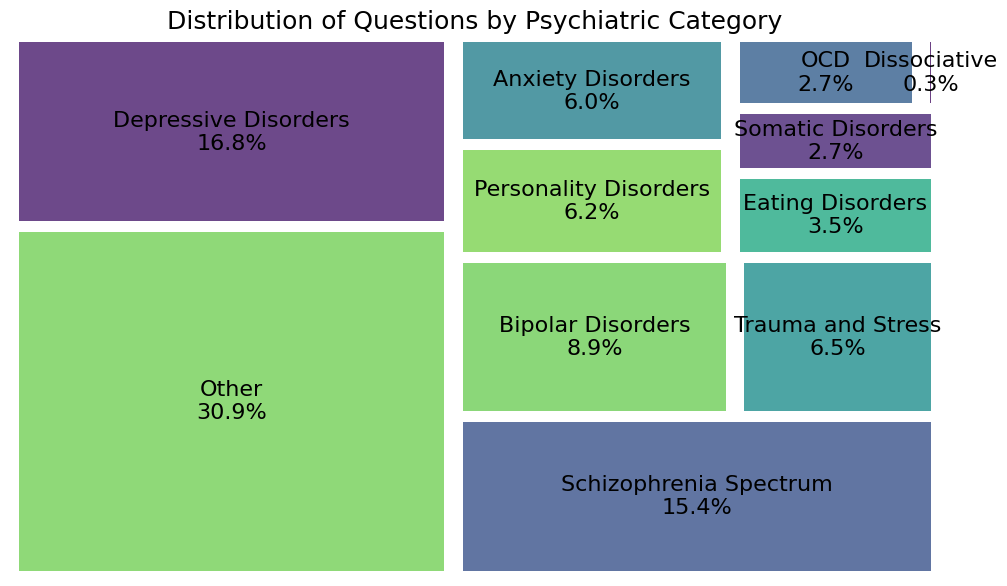

In [6]:
# Read data
with open("advanced_rag/results/DeepSeek V3.json", "r", encoding="utf-8") as f:
    data = json.load(f)
df = pd.DataFrame(data)

# Shorten category names
category_rename = {
    "Schizophrenia Spectrum and Other Psychotic Disorders": "Schizophrenia Spectrum",
    "Trauma and Stressor Related Disorders": "Trauma and Stress",
    "Obsessive-Compulsive Disorders": "OCD",
    "Other Mental Disorders": "Other",
    "Dissociative Disorders": "Dissociative"
}
df['psychiatric_category'] = df['psychiatric_category'].replace(category_rename)

# Count questions per category
cat_counts = df['psychiatric_category'].value_counts()



# Calculate percentages
total = cat_counts.sum()
percentages = cat_counts / total * 100

# Prepare labels with category and percentage
labels = [f"{cat}\n{pct:.1f}%" for cat, pct in zip(cat_counts.index, percentages)]

# Plot treemap
plt.figure(figsize=(12, 7))
squarify.plot(sizes=cat_counts.values, label=labels, alpha=0.8, pad=True, text_kwargs={'fontsize': 16})
plt.axis('off')
plt.title("Distribution of Questions by Psychiatric Category", fontsize=18)
plt.show()

If we omit dissociative disorders category since it is only one question and other category since it is too broad description, we can see proportion of categories are left. 

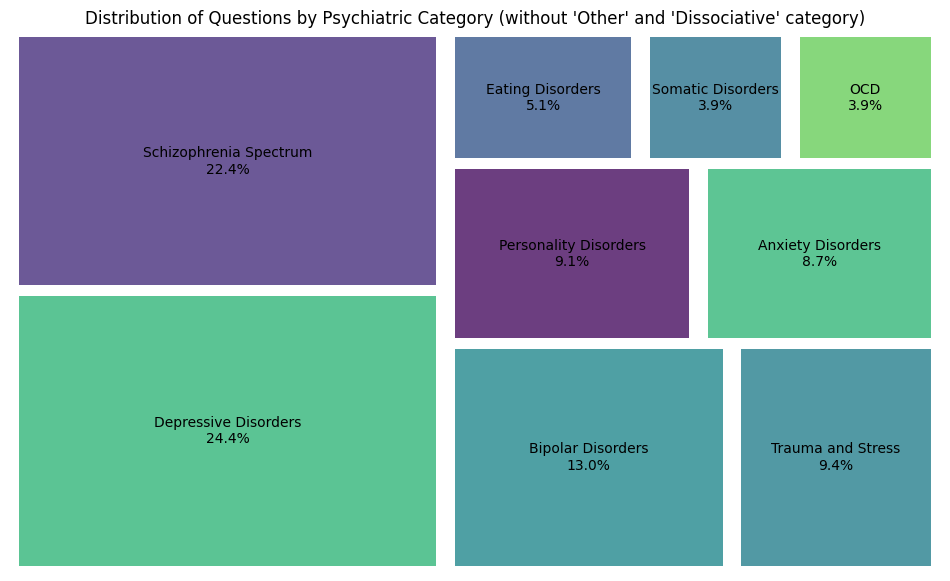

In [7]:
# Count questions per category
cat_counts = df['psychiatric_category'].value_counts()

# Remove "Other" and "Dissociative"
cat_counts = cat_counts.drop(["Other", "Dissociative"], errors="ignore")

# Calculate percentages
total = cat_counts.sum()
percentages = cat_counts / total * 100

# Prepare labels with category and percentage
labels = [f"{cat}\n{pct:.1f}%" for cat, pct in zip(cat_counts.index, percentages)]

# Plot treemap
plt.figure(figsize=(12, 7))
squarify.plot(sizes=cat_counts.values, label=labels, alpha=0.8, pad=True)
plt.axis('off')
plt.title("Distribution of Questions by Psychiatric Category (without 'Other' and 'Dissociative' category)")
plt.show()

## Evaluation of results

At the first step, we compare overall model performance for answer similarity, answer relevancy, and rubric score. 

## RAGAS Answer semantic similarity  

This evaluation is based on the ground truth and the answer, with values falling within the range of 0 to 1. A higher score signifies a better alignment 
between the generated answer and the ground truth.  
Step 1: Vectorize the ground truth answer using the specified embedding model.  
Step 2: Vectorize the generated answer using the same embedding model.  
Step 3: Compute the cosine similarity between the two vectors.  

The metric is a part of RAGAS Answer Correctness metric. The Answer Correctness's final score is created by taking a weighted average of the factual correctness (F1 score) and the semantic similarity. 
(By default, there is a 0.75 : 0.25 weighting.)   


Total API Calls: 2
* 1 embedding call to embed the ground truth
* 1 embedding call to embed the AI answer  

Since the output is deterministic, we run evaluation only once for each question.   
We use Google Gemini embeddings 004 model as one of state-of-the-art models [Paper](https://arxiv.org/html/2503.07891v1)

Sources:  
* [Ragas Docs for semantic similarity](https://docs.ragas.io/en/v0.1.21/concepts/metrics/semantic_similarity.html)   
* https://github.com/dkhundley/llm-rag-guide/blob/main/notebooks/ragas.ipynb

In [8]:
compare_overall_answer_similarity_all_models("naive_rag/results")

Overall Answer Similarity Results:


,Model,Vanilla Mean Similarity,Vanilla 95% CI,RAG Mean Similarity,RAG 95% CI,Difference,P Value,Significant
0,Google Gemma 3n E4B-it,0.83,[0.83 - 0.84],0.84,[0.84 - 0.85],0.01,0.0000,Yes
1,Meta Llama 3.2 3B Instruct Turbo,0.83,[0.82 - 0.83],0.83,[0.82 - 0.83],0.00,0.8226,No
2,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,0.86,[0.86 - 0.87],0.86,[0.86 - 0.87],-0.00,0.0494,Yes
3,Meta Llama 4 Scout 17B-16E Instruct,0.87,[0.86 - 0.87],0.86,[0.86 - 0.87],-0.00,0.0153,Yes
4,Qwen 2.5-72B-Instruct-Turbo,0.85,[0.85 - 0.86],0.85,[0.84 - 0.85],-0.01,0.0000,Yes
5,Qwen3 235B A22B,0.84,[0.84 - 0.85],0.83,[0.83 - 0.84],-0.01,0.0000,Yes


The introduction of RAG, whether naive or advanced, does not improve answer similarity compared to vanilla models. In most cases, answer similarity slightly decreases with RAG, although the absolute difference is minimal (typically less than 0.02). This suggests that simply adding retrieved content—without further processing or summarization—does not enhance the semantic alignment of model answers with the ground truth.


In [9]:
compare_overall_answer_similarity_all_models("advanced_rag/results")  

Overall Answer Similarity Results:


,Model,Vanilla Mean Similarity,Vanilla 95% CI,RAG Mean Similarity,RAG 95% CI,Difference,P Value,Significant
0,DeepSeek V3,0.87,[0.86 - 0.87],0.87,[0.87 - 0.88],0.00,0.5787,No
1,Google Gemma 3n E4B-it,0.87,[0.86 - 0.87],0.86,[0.86 - 0.87],-0.00,0.0192,Yes
2,LG AI ExaOne 3.5 32B Instruct,0.87,[0.87 - 0.88],0.87,[0.86 - 0.87],-0.00,0.3237,No
3,Meta Llama 3.1 8B Instruct Turbo,0.87,[0.87 - 0.88],0.86,[0.85 - 0.86],-0.01,0.0000,Yes
4,Meta Llama 3.2 3B Instruct Turbo,0.86,[0.86 - 0.87],0.85,[0.85 - 0.86],-0.01,0.0122,Yes
5,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,0.88,[0.87 - 0.88],0.88,[0.87 - 0.88],-0.00,0.5361,No
6,Meta Llama 4 Scout 17B-16E Instruct,0.88,[0.87 - 0.88],0.88,[0.87 - 0.88],-0.00,0.0144,Yes
7,Mistral Small 24B Instruct-2501,0.88,[0.87 - 0.88],0.87,[0.86 - 0.88],-0.01,0.0000,Yes
8,MoonshotAI Kimi K2,0.84,[0.83 - 0.84],0.85,[0.84 - 0.85],0.01,0.0000,Yes
9,Qwen 2.5-72B-Instruct-Turbo,0.88,[0.88 - 0.89],0.88,[0.87 - 0.88],-0.01,0.0000,Yes


In 9 out of 11 models, RAG does not improve and often reduces answer similarity to compared to vanilla models.   

* The only model that have slight increase of metric is DeepSeekV3. The difference is not statistically significant. Only Kimi model has a minimal statistically significant increase.  
* For Llama 4 Scout, Gemma3n, Qwen 2.5, Llama 3.2 3B, Mistral 24B, Llama 3.1 8B, Qwen 3 the reduction in answer similarity is statistically significant. However, the biggest difference is no more than 2%.   

* Slight increase in metric could be attributed towards change in prompt (for advanced RAG we provided models with one-shot example).  

Conslusion:  
Both naive and advanced RAG pipelines do not provide a meaningful improvement in answer similarity and often slightly reduce it, with most differences being statistically significant but very small. 

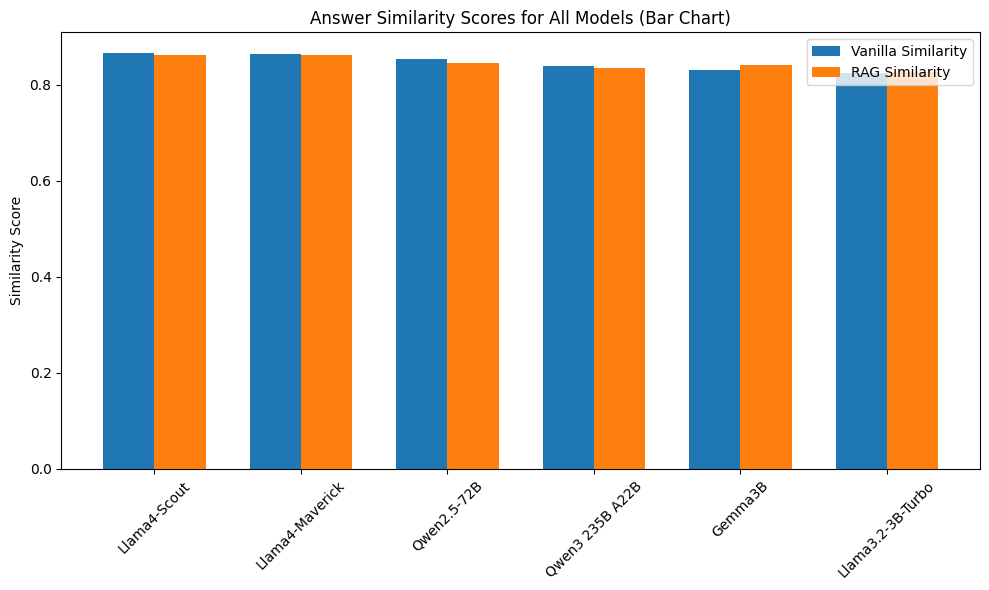

In [10]:
plot_answer_similarity_all_models_bar_chart("naive_rag/results")

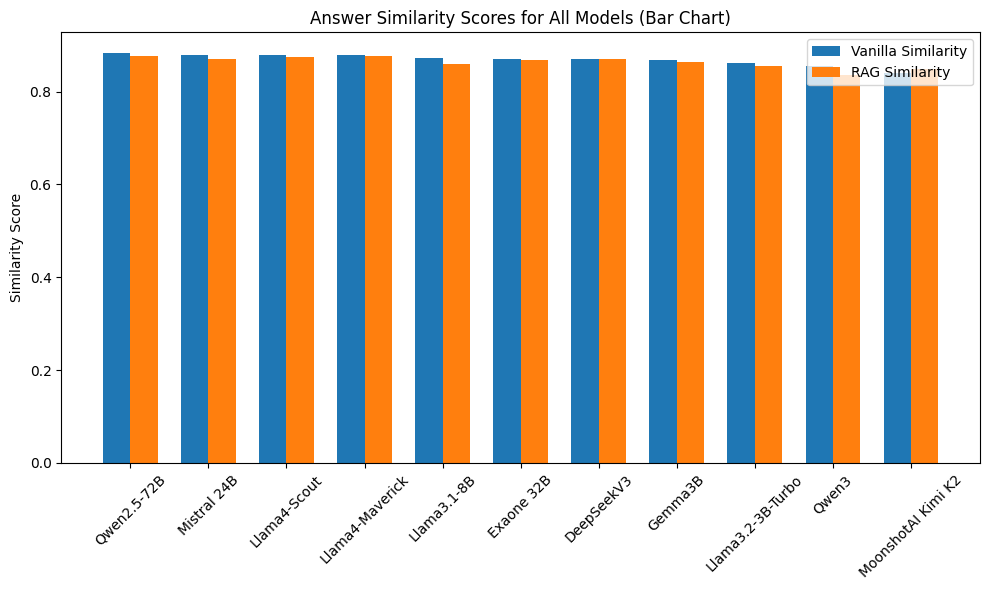

In [11]:
plot_answer_similarity_all_models_bar_chart("advanced_rag/results")

Overall, answer similarity scores for all models are above 0.8. It is possible that questions from dataset were used as a part of training data for models, contributing to data leakage problem. 

## RAGAS Answer Relevance  

The Answer Relevance metric evaluates to what extent the generated answer addresses the provided question. The answer is considered relevant if it directly addresses the question.    
* Step 1: Reverse-engineer ‘n’ variants of the question from the generated answer using a LLM (prompt: "Generate a question for the given answer.
answer: [answer])")  
* Step 2: Generate embedding for all the questions. Calculate the mean cosine similarity between the generated questions and the actual question.  

The Answer Relevance doesn't assess factual correctness of generated answer but rather penalises redundant or insufficient answers.  

Total API Calls by default: 4  
* 1 LLM call to generate the question based on the answer (by default - 3 question)  
* 1 embedding call for each generated question   (by default - 3) 
* 1 embedding call to embed the original question  

We set LLM temperature to 0.0 and still run evaluation 3 times. The metric is produced relatively fast still, but in such a fashion we diminish the influence of non-deterministic output. Sometimes all 3 evaluations have the same results and sometimes they are slightly different.  

Sources:  
* [RAGAS Documentation](https://docs.ragas.io/en/v0.1.21/concepts/metrics/answer_relevance.html)  
* [Original RAGAS paper](https://arxiv.org/abs/2309.15217)  

In [12]:
compare_overall_answer_relevancy_all_models("naive_rag/results")

Overall Answer Relevancy Results:


,Model,Vanilla Mean Relevancy,Vanilla 95% CI,RAG Mean Relevancy,RAG 95% CI,Difference,P Value,Significant
0,Google Gemma 3n E4B-it,0.62,[0.60 - 0.65],0.64,[0.62 - 0.66],0.02,0.1842,No
1,Meta Llama 3.2 3B Instruct Turbo,0.45,[0.42 - 0.49],0.56,[0.53 - 0.58],0.10,0.0000,Yes
2,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,0.71,[0.70 - 0.72],0.71,[0.69 - 0.72],-0.00,0.6888,No
3,Meta Llama 4 Scout 17B-16E Instruct,0.68,[0.66 - 0.69],0.64,[0.62 - 0.66],-0.03,0.0024,Yes
4,Qwen 2.5-72B-Instruct-Turbo,0.67,[0.65 - 0.69],0.67,[0.66 - 0.69],0.00,0.7758,No
5,Qwen3 235B A22B,0.69,[0.66 - 0.71],0.66,[0.64 - 0.69],-0.02,0.1519,No


In [13]:
compare_overall_answer_relevancy_all_models("advanced_rag/results")  

Overall Answer Relevancy Results:


,Model,Vanilla Mean Relevancy,Vanilla 95% CI,RAG Mean Relevancy,RAG 95% CI,Difference,P Value,Significant
0,DeepSeek V3,0.66,[0.66 - 0.67],0.62,[0.60 - 0.64],-0.05,0.0000,Yes
1,Google Gemma 3n E4B-it,0.68,[0.67 - 0.70],0.58,[0.55 - 0.61],-0.10,0.0000,Yes
2,LG AI ExaOne 3.5 32B Instruct,0.66,[0.64 - 0.67],0.62,[0.60 - 0.64],-0.04,0.0028,Yes
3,Meta Llama 3.1 8B Instruct Turbo,0.69,[0.68 - 0.70],0.64,[0.62 - 0.66],-0.05,0.0000,Yes
4,Meta Llama 3.2 3B Instruct Turbo,0.64,[0.62 - 0.66],0.57,[0.54 - 0.60],-0.07,0.0000,Yes
5,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,0.70,[0.69 - 0.71],0.65,[0.63 - 0.67],-0.05,0.0000,Yes
6,Meta Llama 4 Scout 17B-16E Instruct,0.69,[0.68 - 0.70],0.62,[0.60 - 0.64],-0.07,0.0000,Yes
7,Mistral Small 24B Instruct-2501,0.68,[0.67 - 0.69],0.63,[0.62 - 0.65],-0.05,0.0000,Yes
8,MoonshotAI Kimi K2,0.65,[0.64 - 0.65],0.57,[0.55 - 0.60],-0.07,0.0000,Yes
9,Qwen 2.5-72B-Instruct-Turbo,0.66,[0.65 - 0.67],0.64,[0.62 - 0.65],-0.02,0.0081,Yes


Conclusion:  
RAG statistically significant reduces answer relevancy across all tested models.   
The reduction in answer relevancy with RAG observed across models of all sizes. For example, for large models like Llama 4 family decrease is greater than for Mistral 24B. Augmentation of context introduce distractions or noisy information, and incresing model's size to mitigate this scenario is not sufficient. 

In [14]:
#plot_answer_relevancy_all_models_line("naive_rag/results")

In [15]:
#plot_answer_relevancy_all_models_line("advanced_rag/results")

In [16]:
compare_relevancy_by_category('advanced_rag/results', categories)

Answer Relevancy Results for Category: Depressive Disorders


,Model,Vanilla Mean Relevancy,Vanilla 95% CI,RAG Mean Relevancy,RAG 95% CI,Difference,P Value,Significant
0,LG AI ExaOne 3.5 32B Instruct,0.681791,[0.64 - 0.72],0.656300,[0.61 - 0.70],-0.025491,0.3871,No
1,DeepSeek V3,0.680580,[0.66 - 0.70],0.644969,[0.60 - 0.69],-0.035611,0.1351,No
2,Mistral Small 24B Instruct-2501,0.704164,[0.68 - 0.72],0.665840,[0.62 - 0.71],-0.038324,0.1015,No
3,Meta Llama 4 Scout 17B-16E Instruct,0.707432,[0.69 - 0.73],0.666343,[0.62 - 0.71],-0.041089,0.0852,No
4,Meta Llama 3.1 8B Instruct Turbo,0.701569,[0.68 - 0.72],0.650641,[0.60 - 0.70],-0.050928,0.0861,No
5,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,0.713092,[0.69 - 0.73],0.647708,[0.60 - 0.70],-0.065384,0.0149,Yes
6,MoonshotAI Kimi K2,0.667124,[0.65 - 0.69],0.598635,[0.54 - 0.66],-0.068489,0.0372,Yes
7,Meta Llama 3.2 3B Instruct Turbo,0.640830,[0.59 - 0.69],0.567412,[0.50 - 0.64],-0.073418,0.0937,No
8,Qwen 2.5-72B-Instruct-Turbo,0.687901,[0.67 - 0.71],0.603818,[0.55 - 0.66],-0.084083,0.0096,Yes
9,Google Gemma 3n E4B-it,0.686731,[0.65 - 0.72],0.558988,[0.48 - 0.63],-0.127743,0.0010,Yes


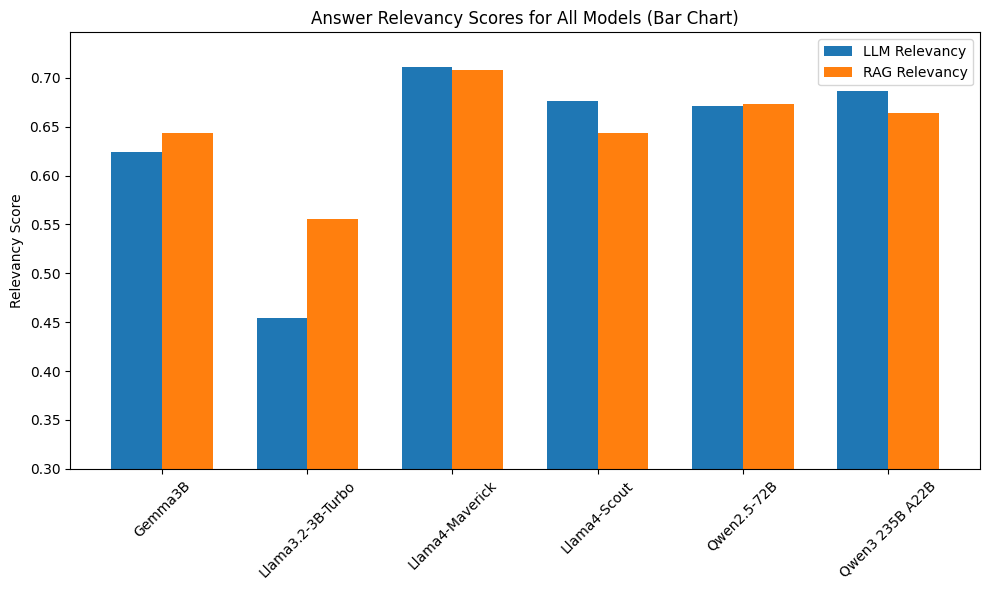

In [17]:
plot_answer_relevancy_all_models_bar_chart("naive_rag/results")

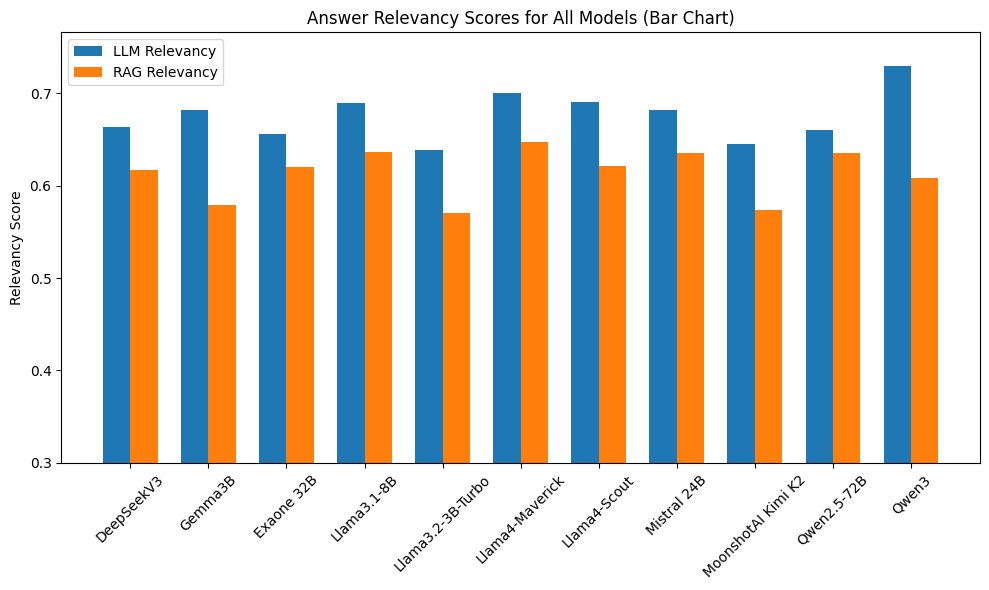

In [18]:
plot_answer_relevancy_all_models_bar_chart("advanced_rag/results")

### Rubric score


While metrics like answer similarity and answer relevancy focus on semantic closeness to ground truth, they can miss nuanced clinical rerasoning or evaluate higher truthfully looking response. We adapted Likert scale for human preferences of response, based on rationale that LLM responses show close alignment with human preference via RLHF and DPO.  

* Score 1: "The answer is medically incorrect or contradicts established psychiatric knowledge; it does not address the question or ground truth at all."  
* Score 2: "The answer contains significant inaccuracies or omissions; it only partially addresses the question and differs notably from the ground truth."  
* Score 3: "The answer is generally correct but lacks important details or contains minor inaccuracies; it is somewhat aligned with the ground truth."  
* Score 4: "The answer is medically accurate, covers most relevant aspects, and closely matches the ground truth with only minor differences."  
* Score 5: "The answer is fully medically accurate, comprehensive, and matches the ground truth exactly in content and detail" 

[Paper](https://arxiv.org/pdf/2503.14504)

In [19]:
compare_overall_rubric_score_all_models("naive_rag/results")

Overall Rubric Score Results:


,Model,Vanilla Mean Rubric,Vanilla 95% CI,RAG Mean Rubric,RAG 95% CI,Difference,P Value,Significant
0,Google Gemma 3n E4B-it,3.66,[3.55 - 3.76],3.64,[3.53 - 3.75],-0.02,0.0881,No
1,Meta Llama 3.2 3B Instruct Turbo,2.95,[2.83 - 3.08],2.95,[2.83 - 3.08],0.00,0.8790,No
2,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,4.23,[4.15 - 4.30],4.21,[4.13 - 4.28],-0.02,0.1576,No
3,Meta Llama 4 Scout 17B-16E Instruct,4.07,[3.98 - 4.16],4.06,[3.97 - 4.15],-0.01,0.4504,No
4,Qwen 2.5-72B-Instruct-Turbo,3.51,[3.41 - 3.62],3.55,[3.45 - 3.65],0.04,0.0122,Yes
5,Qwen3 235B A22B,4.35,[4.27 - 4.44],4.35,[4.26 - 4.43],-0.01,0.6837,No


In [20]:
compare_overall_rubric_score_all_models("advanced_rag/results")

Overall Rubric Score Results:


,Model,Vanilla Mean Rubric,Vanilla 95% CI,RAG Mean Rubric,RAG 95% CI,Difference,P Value,Significant
0,DeepSeek V3,4.07,[3.97 - 4.18],4.09,[3.99 - 4.19],0.02,0.1576,No
1,Google Gemma 3n E4B-it,3.41,[3.30 - 3.52],3.40,[3.30 - 3.51],-0.01,0.5492,No
2,LG AI ExaOne 3.5 32B Instruct,3.59,[3.47 - 3.70],3.60,[3.49 - 3.72],0.02,0.2211,No
3,Meta Llama 3.1 8B Instruct Turbo,3.27,[3.16 - 3.38],3.25,[3.14 - 3.36],-0.02,0.2398,No
4,Meta Llama 3.2 3B Instruct Turbo,3.01,[2.89 - 3.12],3.00,[2.88 - 3.12],-0.01,0.6954,No
5,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,3.89,[3.79 - 3.99],3.89,[3.79 - 3.99],0.00,0.8530,No
6,Meta Llama 4 Scout 17B-16E Instruct,3.83,[3.73 - 3.93],3.82,[3.72 - 3.92],-0.00,0.8352,No
7,Mistral Small 24B Instruct-2501,3.69,[3.58 - 3.80],3.66,[3.55 - 3.77],-0.02,0.0718,No
8,MoonshotAI Kimi K2,4.08,[3.96 - 4.20],4.07,[3.94 - 4.19],-0.01,0.4505,No
9,Qwen 2.5-72B-Instruct-Turbo,3.82,[3.71 - 3.92],3.82,[3.71 - 3.93],0.01,0.6837,No


There is no statistically significant difference between overall assesment of responses between vanilla and RAG. 

In [21]:
def plot_rubric_score_distribution(folder_path, category=None):
    """
    Create a simple bar plot for rubric score distribution comparing RAG and vanilla.
    
    Args:
        folder_path (str): Path to results folder
        category (str, optional): Psychiatric category to filter by
    """
    dfs = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            model_name = filename.replace('.json', '')
            
            if category is not None:
                df = df[df['psychiatric_category'] == category]
            
            # Keep only needed columns and add model name
            df = df[['Vanilla Rubric Score', 'RAG Rubric Score']].copy()
            df['Model'] = model_name
            dfs.append(df)
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    if not dfs:
        print("No data found.")
        return

    all_df = pd.concat(dfs, ignore_index=True)
    
    # Remove rows with missing data
    all_df = all_df.dropna(subset=['Vanilla Rubric Score', 'RAG Rubric Score'])
    all_df = all_df[(all_df['Vanilla Rubric Score'] != "") & (all_df['RAG Rubric Score'] != "")]
    
    # Convert to numeric
    all_df['Vanilla Rubric Score'] = pd.to_numeric(all_df['Vanilla Rubric Score'])
    all_df['RAG Rubric Score'] = pd.to_numeric(all_df['RAG Rubric Score'])
    
    # Calculate mean scores by model
    mean_scores = all_df.groupby('Model')[['Vanilla Rubric Score', 'RAG Rubric Score']].mean()
    
    # Short model names for better visualization
    short_names = {
        "DeepSeek V3": "DeepSeekV3",
        "Google Gemma 3n E4B-it": "Gemma3B",
        "LG AI ExaOne 3.5 32B Instruct": "Exaone 32B",
        "Meta Llama 3.1 8B Instruct Turbo": "Llama3.1-8B",
        "Meta Llama 4 Maverick 17B-128E-Instruct-FP8": "Llama4-Maverick",
        "Meta Llama 4 Scout 17B-16E Instruct": "Llama4-Scout",
        "Mistral Small 24B Instruct-2501": "Mistral 24B",
        "Qwen 2.5-72B-Instruct-Turbo": "Qwen2.5-72B",
        "Qwen3 235B-A22B-fp8": "Qwen3",
        "Meta Llama 3.2 3B Instruct Turbo": "Llama3.2-3B-Turbo",
    }
    mean_scores['Short Model'] = mean_scores.index.map(lambda x: short_names.get(x, x))
    mean_scores = mean_scores.sort_values('Vanilla Rubric Score', ascending=False)
    
    # Create bar plot
    x = np.arange(len(mean_scores))
    width = 0.35
    
    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, mean_scores['Vanilla Rubric Score'], width, label='LLM', color='skyblue')
    plt.bar(x + width/2, mean_scores['RAG Rubric Score'], width, label='RAG', color='orange')
    
    plt.xlabel('Model')
    plt.ylabel('Mean Rubric Score')
    title = 'Mean Rubric Scores by Model: RAG vs LLM'
    if category:
        title += f' ({category})'
    plt.title(title)
    plt.xticks(x, mean_scores['Short Model'], rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    vanilla_scores = all_df['Vanilla Rubric Score'].values
    rag_scores = all_df['RAG Rubric Score'].values
    
    print("\nSummary Statistics:")
    print("=" * 50)
    print(f"Vanilla - Mean: {vanilla_scores.mean():.2f}, Std: {vanilla_scores.std():.2f}")
    print(f"RAG - Mean: {rag_scores.mean():.2f}, Std: {rag_scores.std():.2f}")
    print(f"Difference (RAG - Vanilla): {rag_scores.mean() - vanilla_scores.mean():.3f}")

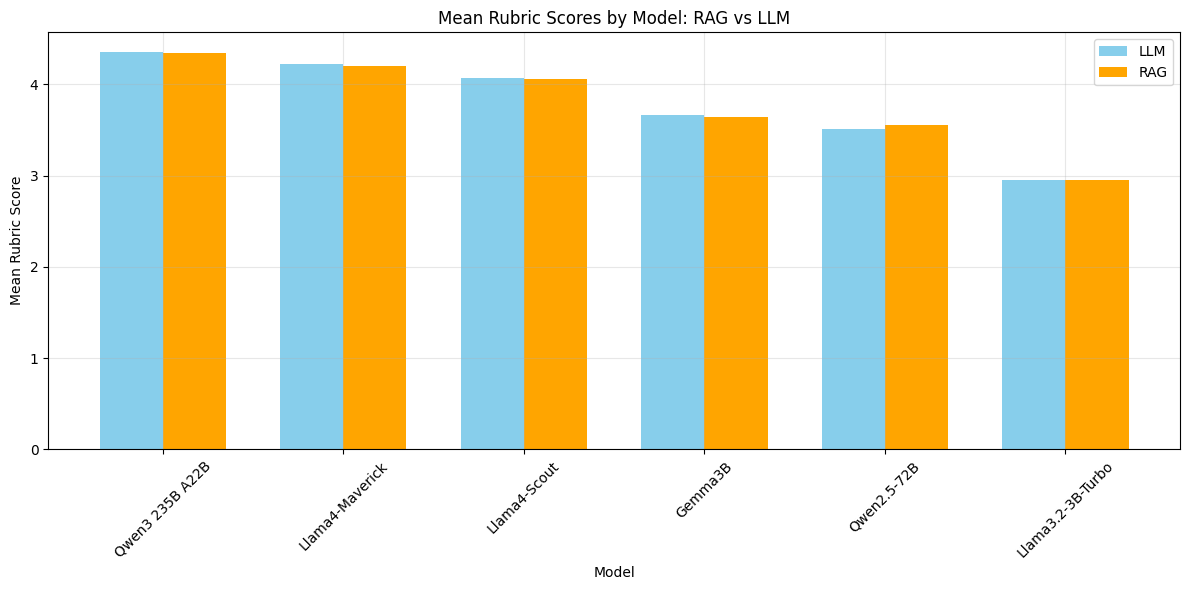


Summary Statistics:
Vanilla - Mean: 3.80, Std: 1.08
RAG - Mean: 3.79, Std: 1.08
Difference (RAG - Vanilla): -0.004


In [22]:
plot_rubric_score_distribution("naive_rag/results")

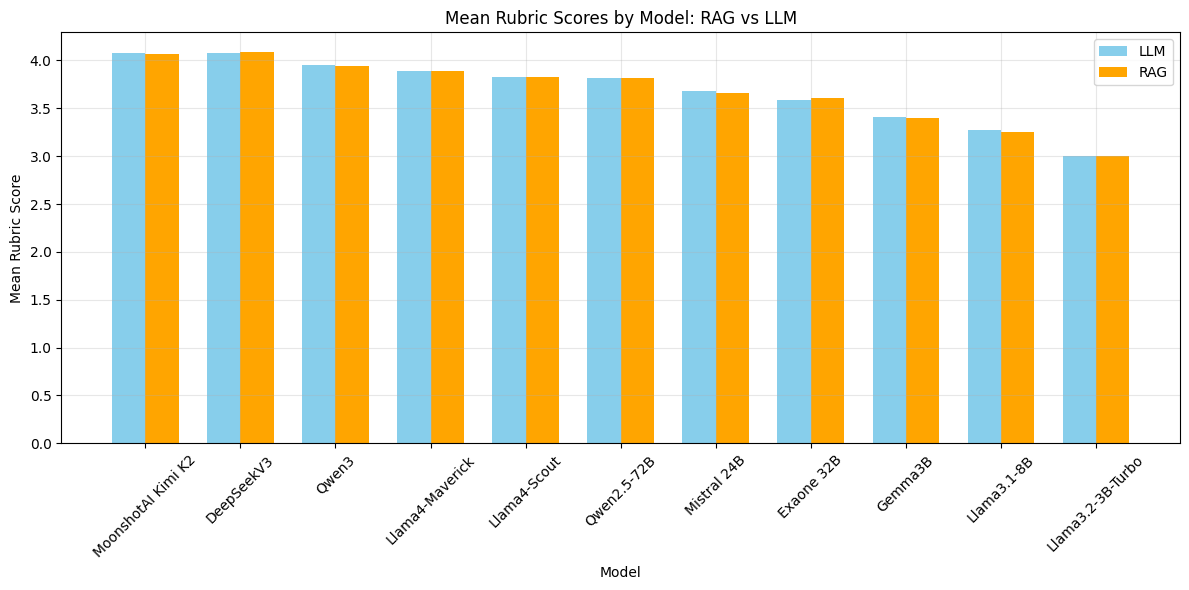


Summary Statistics:
Vanilla - Mean: 3.69, Std: 1.09
RAG - Mean: 3.69, Std: 1.09
Difference (RAG - Vanilla): -0.004


In [23]:
plot_rubric_score_distribution("advanced_rag/results")

In [24]:
from scipy.stats import ttest_rel

file_path = "advanced_rag/results/Google Gemma 3n E4B-it.json"
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)
df = pd.DataFrame(data)

# Assuming df['Vanilla Rubric Score'] and df['RAG Rubric Score'] are already floats and aligned
t_stat, p_value = ttest_rel(df['RAG Rubric Score'], df['Vanilla Rubric Score'])
print("t_stat:", t_stat)
print("p_value:", p_value)

print("Any NaN in Vanilla?", df['Vanilla Rubric Score'].isna().any())
print("Any NaN in RAG?", df['RAG Rubric Score'].isna().any())
print("All differences zero?", np.allclose(df['RAG Rubric Score'], df['Vanilla Rubric Score']))

t_stat: -0.59947894041409
p_value: 0.5492224477548315
Any NaN in Vanilla? False
Any NaN in RAG? False
All differences zero? False


Sometimes when we inspect answer by category, we see nan result in the output. The nan in the result by category means that the rubric scores for vanilla and RAG are exatcly the same for every sample. p_value: nan means "no difference to test". If all paired values are numerically equal, you get a p-value of 1.

# RAG Metrics  

RAG metrics cannot be compared with vanilla models, they are used to assess orevall performance of RAG pipeline. 
## RAGAS Faithfulness 

Definition:  
Faithfulness or groundness is sometimes used interchangeably.  

The process:  
Faithfulness measures the factual consistency of the generated answer against the given context. It is calculated from the answer and the retrieved context. The answer is scaled to the (0, 1) range. The higher the better. A low faithfulness metric indicates that the language model outputs response without correct utilisation of provided context or doesn't find any relevant passages in it.   
The generated answer is regarded as faithful if all the claims made in the answer can be inferred from the given context.  
* At the first step, the generated answer is broken down into individual statements.     
* At the next step, each of these claims is cross-checked with the given context to determine if it can be inferred from the context.    
* The final score is calculated by dividing the number of claims that can be inferred from the context by the total number of claims in the generated response.    

We set LLM temperature to 0.0 and still run evaluation 3 times. The metric is produced relatively fast still, but in such a fashion we diminish the influence of non-deterministic output. Sometimes all 3 evaluations have the same results and sometimes they are slightly different.  

Source:  
* [RAGAS Docs for Faitfulness](https://docs.ragas.io/en/v0.1.21/concepts/metrics/faithfulness.html)   
* [Microsoft Learn End-to-end LLM evaluation](https://learn.microsoft.com/en-us/azure/architecture/ai-ml/guide/rag/rag-llm-evaluation-phase)  


In [25]:
summarize_rag_metric_all_questions("naive_rag/results", "faithfulness")

Faithfulness (RAG only) Results for ALL questions:


,Model,Mean faithfulness,95% CI
0,Google Gemma 3n E4B-it,0.37,[0.34 - 0.40]
1,Meta Llama 3.2 3B Instruct Turbo,0.38,[0.36 - 0.41]
2,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,0.29,[0.26 - 0.32]
3,Meta Llama 4 Scout 17B-16E Instruct,0.36,[0.34 - 0.39]
4,Qwen 2.5-72B-Instruct-Turbo,0.39,[0.36 - 0.41]
5,Qwen3 235B A22B,0.27,[0.19 - 0.35]


In [26]:
summarize_rag_metric_all_questions("advanced_rag/results", "faithfulness")

Faithfulness (RAG only) Results for ALL questions:


,Model,Mean faithfulness,95% CI
0,DeepSeek V3,0.44,[0.41 - 0.47]
1,Google Gemma 3n E4B-it,0.51,[0.48 - 0.53]
2,LG AI ExaOne 3.5 32B Instruct,0.46,[0.43 - 0.48]
3,Meta Llama 3.1 8B Instruct Turbo,0.40,[0.37 - 0.42]
4,Meta Llama 3.2 3B Instruct Turbo,0.46,[0.43 - 0.49]
5,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,0.43,[0.40 - 0.45]
6,Meta Llama 4 Scout 17B-16E Instruct,0.45,[0.42 - 0.48]
7,Mistral Small 24B Instruct-2501,0.48,[0.45 - 0.51]
8,MoonshotAI Kimi K2,0.50,[0.46 - 0.53]
9,Qwen 2.5-72B-Instruct-Turbo,0.42,[0.39 - 0.45]


* All models are below 0.5 which suggests that, on average, less than 50% of the answer content is directly supported by the retrieved context.  
* Differences between models are moderate (best vs. worst is about 0.11 points).  

All models struggle to generate answers that are fully supported by the retrieved context. This situation highlights the need for further improvements in retrieval pipeline.

In [27]:
def summarize_rag_metric_by_category(folder_path, categories, metric_prefix):
    """
    Summarize a RAG-only metric (e.g., faithfulness, context precision) by category and model.
    
    Args:
        folder_path (str): Path to results folder.
        categories (list): List of psychiatric categories.
        metric_prefix (str): Prefix for metric columns, e.g. "faithfulness" or "context_precision".
    """
    for category in categories:
        results = []
        for filename in os.listdir(folder_path):
            if not filename.endswith('.json'):
                continue
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                df = pd.DataFrame(data)
                df = df[df['psychiatric_category'] == category]
                metric_cols = [
                    f"{metric_prefix} for RAG run 1",
                    f"{metric_prefix} for RAG run 2",
                    f"{metric_prefix} for RAG run 3"
                ]
                for col in metric_cols:
                    if col not in df.columns:
                        df[col] = np.nan
                df[f"Mean {metric_prefix} for RAG"] = df[metric_cols].astype(float).mean(axis=1, skipna=True)
                metric_values = df[f"Mean {metric_prefix} for RAG"].dropna().values
                if len(metric_values) > 1:
                    mean, lower, upper, margin = calculate_confidence_interval(metric_values)
                    results.append({
                        'Model': filename.replace('.json', ''),
                        f'Mean {metric_prefix}': mean,
                        '95% CI': f"[{lower:.4f} - {upper:.4f}]",
                        'N': len(metric_values)
                    })
                else:
                    print(f"Insufficient {metric_prefix} data for category '{category}' in {filename}. Skipping.")
            except Exception as e:
                print(f"Failed to process {filename}: {e}")


        # Output results
        drop_cols = ['N']

        if results:
            results_df = pd.DataFrame(results)
            results_df = results_df.sort_values(f'Mean {metric_prefix}', ascending=False)
            results_df = results_df.drop(columns=[col for col in drop_cols if col in results_df.columns])
            print(f"{metric_prefix.capitalize()} (RAG only) Results for Category: {category}")
            display(results_df.reset_index(drop=True))



In [28]:
def plot_rag_metric_all_models(folder_path, metric_prefix, category=None):
    """
    Plot a RAG-only metric (e.g., faithfulness, context_precision, context_recall) for all models.
    Args:
        folder_path (str): Path to results folder.
        metric_prefix (str): Prefix for metric columns, e.g. "faithfulness" or "context_precision".
        category (str or None): Psychiatric category to filter by (optional).
    """
    results = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            if category is not None:
                df = df[df['psychiatric_category'] == category]
            metric_cols = [
                f"{metric_prefix} for RAG run 1",
                f"{metric_prefix} for RAG run 2",
                f"{metric_prefix} for RAG run 3"
            ]
            for col in metric_cols:
                if col not in df.columns:
                    df[col] = np.nan
            df[f"Mean {metric_prefix} for RAG"] = df[metric_cols].astype(float).mean(axis=1, skipna=True)
            metric_values = df[f"Mean {metric_prefix} for RAG"].dropna().values
            if len(metric_values) > 0:
                results.append({
                    'Model': filename.replace('.json', ''),
                    f'Mean {metric_prefix}': metric_values.mean()
                })
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    if not results:
        print(f"No data found for metric '{metric_prefix}' and category: {category}")
        return

    results_df = pd.DataFrame(results)
    results_df.set_index('Model', inplace=True)

    short_names = {
        "DeepSeek V3": "DeepSeekV3",
        "Google Gemma 3n E4B-it": "Gemma3B",
        "LG AI ExaOne 3.5 32B Instruct": "Exaone 32B",
        "Meta Llama 3.1 8B Instruct Turbo": "Llama3.1-8B",
        "Meta Llama 4 Maverick 17B-128E-Instruct-FP8": "Llama4-Maverick",
        "Meta Llama 4 Scout 17B-16E Instruct": "Llama4-Scout",
        "Mistral Small 24B Instruct-2501": "Mistral 24B",
        "Qwen 2.5-72B-Instruct-Turbo": "Qwen2.5-72B",
        "Qwen3 235B-A22B-fp8": "Qwen3"
    }

    results_df['Short Model'] = results_df.index.map(lambda x: short_names.get(x, x))

    plt.figure(figsize=(10, 6))
    plt.plot(results_df['Short Model'], results_df[f'Mean {metric_prefix}'], marker='o', label=f'RAG {metric_prefix.capitalize()}')
    title = f"{metric_prefix.capitalize()} (RAG only) Scores for All Models"
    if category:
        title += f" ({category})"
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel(f'{metric_prefix.capitalize()} Score')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

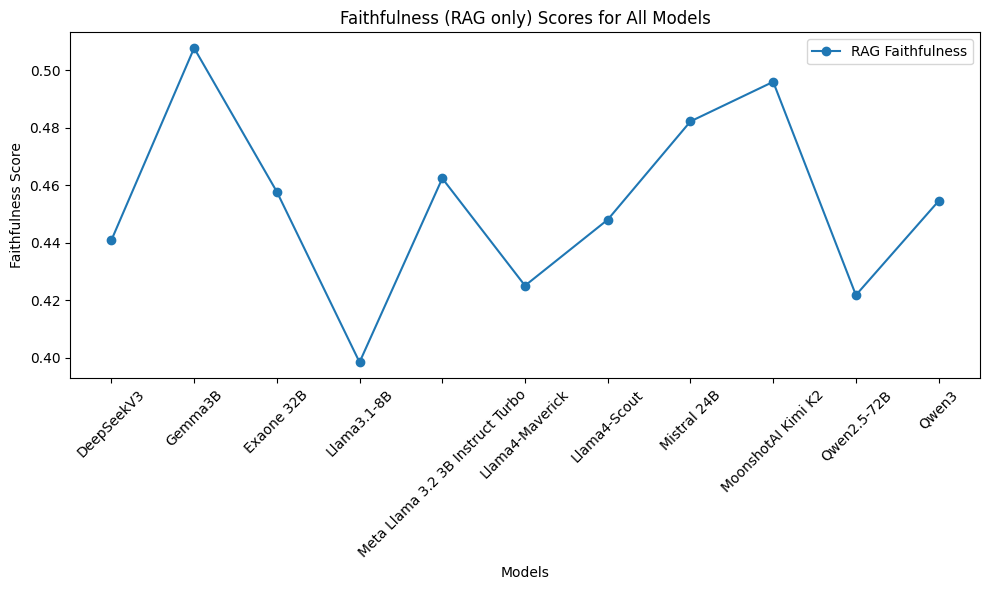

In [29]:
plot_rag_metric_all_models("advanced_rag/results", "faithfulness")

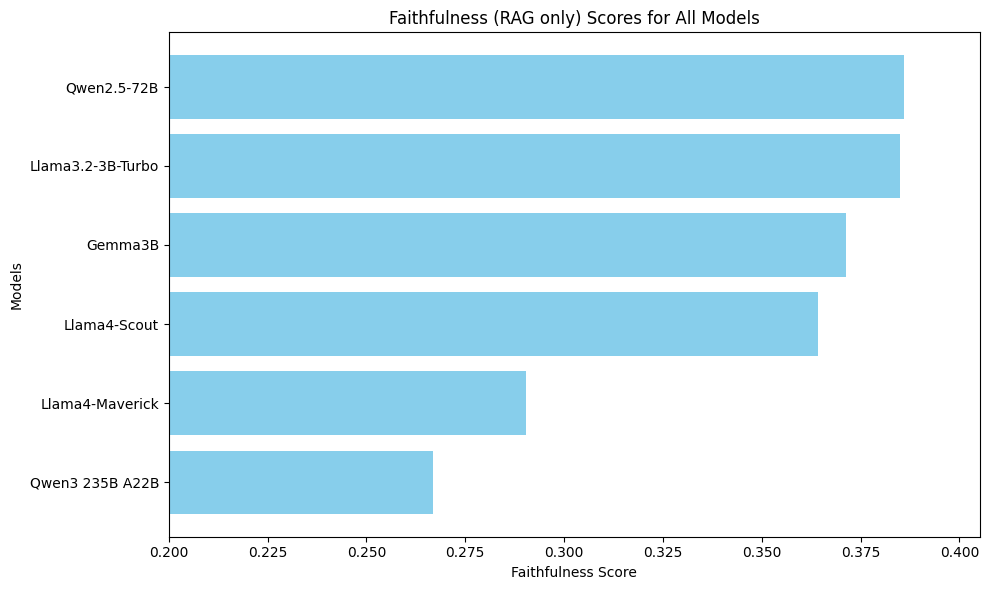

In [30]:
plot_rag_metric_all_models_barh('naive_rag/results', 'faithfulness', category=None, xlim_left=0.2)

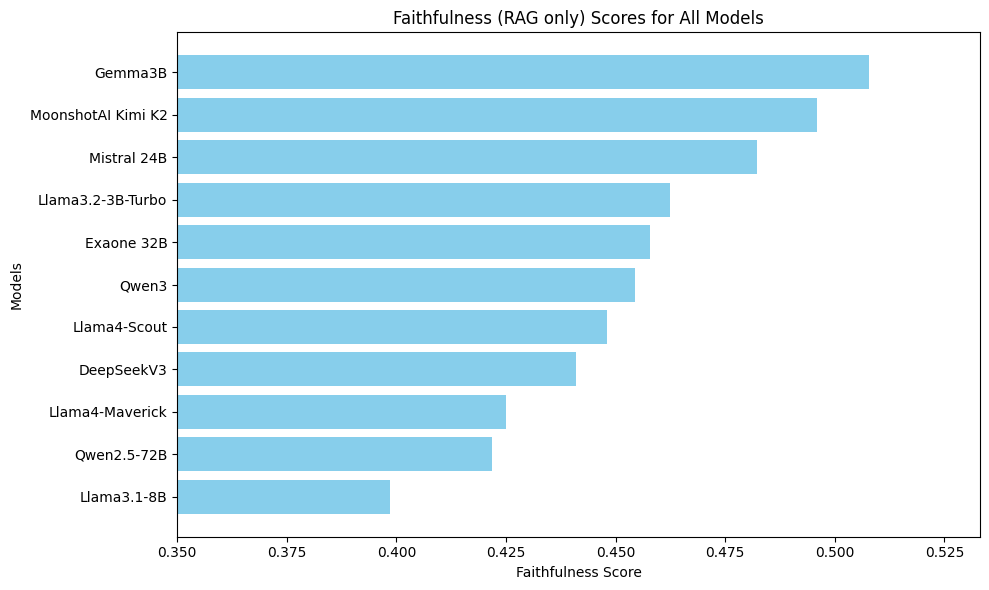

In [31]:
plot_rag_metric_all_models_barh("advanced_rag/results", "faithfulness")

## Context Recall  
Context recall approximates the extent to which retrieved information can be used to generate a ground truth (GT) answer.  The answer is broken down into individual statements and analysed to determine whether it can be inferred from the context.   
Context recall = (GT claims that can be attributed to context) / (number of claims in GT)  
The value of the resulting metric is between 0 and 1.   


In [32]:
summarize_rag_metric_all_questions("naive_rag/results", "context_recall")

Context_recall (RAG only) Results for ALL questions:


,Model,Mean context_recall,95% CI
0,Google Gemma 3n E4B-it,0.27,[0.23 - 0.31]
1,Meta Llama 3.2 3B Instruct Turbo,0.27,[0.23 - 0.30]
2,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,0.27,[0.23 - 0.31]
3,Meta Llama 4 Scout 17B-16E Instruct,0.28,[0.24 - 0.31]
4,Qwen 2.5-72B-Instruct-Turbo,0.27,[0.23 - 0.31]
5,Qwen3 235B A22B,0.27,[0.23 - 0.31]


In [33]:
summarize_rag_metric_all_questions("advanced_rag/results", "context_recall")

Context_recall (RAG only) Results for ALL questions:


,Model,Mean context_recall,95% CI
0,DeepSeek V3,0.40,[0.36 - 0.43]
1,Google Gemma 3n E4B-it,0.31,[0.28 - 0.35]
2,LG AI ExaOne 3.5 32B Instruct,0.35,[0.32 - 0.39]
3,Meta Llama 3.1 8B Instruct Turbo,0.35,[0.31 - 0.38]
4,Meta Llama 3.2 3B Instruct Turbo,0.34,[0.30 - 0.37]
5,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,0.38,[0.34 - 0.41]
6,Meta Llama 4 Scout 17B-16E Instruct,0.40,[0.36 - 0.44]
7,Mistral Small 24B Instruct-2501,0.39,[0.35 - 0.42]
8,MoonshotAI Kimi K2,0.45,[0.42 - 0.49]
9,Qwen 2.5-72B-Instruct-Turbo,0.59,[0.37 - 0.81]


Most of the model utilise between 30 and 40 percents of retrieved context in their responses.  
* The best model Qwen 2.5 has the highest context recall score, but with wide confidence interval, marking inconsistent results.  

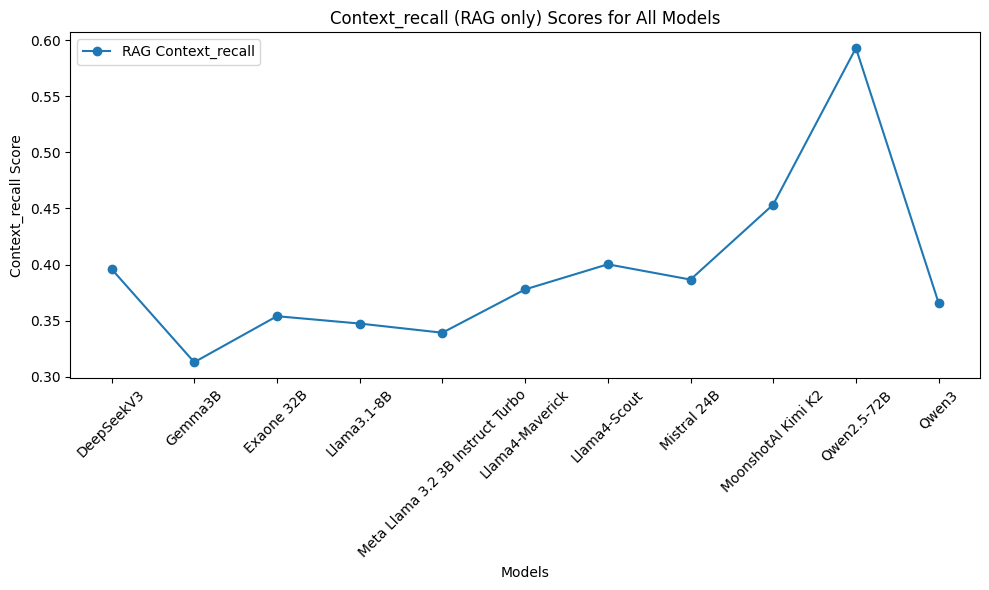

In [34]:
plot_rag_metric_all_models("advanced_rag/results", "context_recall")

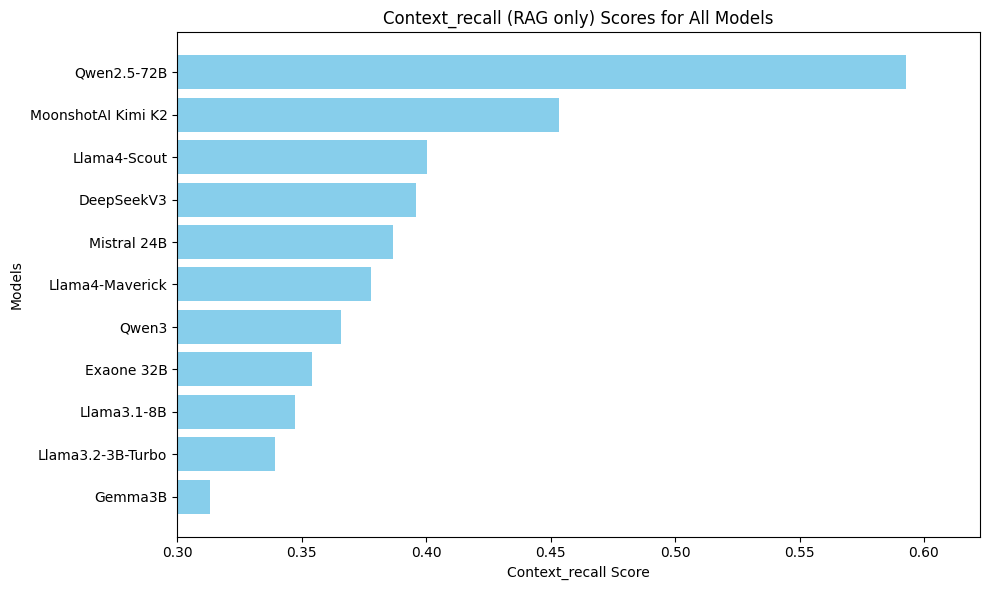

In [61]:
plot_rag_metric_all_models_barh("advanced_rag/results", "context_recall", xlim_left=0.3)

## Context Precision  
Context Precision metric measures whether the retrieved context contains relevant items to generate a response similar to the reference. The metric is computed using the question, the ground truth, and the retrieved contexts, and its values range from 0 to 1, where higher scores indicate better precision in retrieving.   
For each chunk of context, RAGAS checks whether it can be used to arrive at the ground truth and calculates the precision score.   
The final score is the mean of the precision scores of k chunks (from top_k of the retriever). We set the LLM temperature to 0.0 and still run the evaluation 3 times.  



Source:  
[RAGAS Docs](https://docs.ragas.io/en/v0.1.21/concepts/metrics/context_precision.html)

In [37]:
summarize_rag_metric_all_questions("naive_rag/results", "context_precision")

Context_precision (RAG only) Results for ALL questions:


,Model,Mean context_precision,95% CI
0,Google Gemma 3n E4B-it,0.30,[0.26 - 0.35]
1,Meta Llama 3.2 3B Instruct Turbo,0.30,[0.26 - 0.35]
2,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,0.31,[0.26 - 0.35]
3,Meta Llama 4 Scout 17B-16E Instruct,0.31,[0.27 - 0.36]
4,Qwen 2.5-72B-Instruct-Turbo,0.31,[0.26 - 0.35]
5,Qwen3 235B A22B,0.30,[0.25 - 0.35]


In [38]:
summarize_rag_metric_all_questions("advanced_rag/results", "context_precision")

Context_precision (RAG only) Results for ALL questions:


,Model,Mean context_precision,95% CI
0,DeepSeek V3,0.46,[0.42 - 0.50]
1,Google Gemma 3n E4B-it,0.30,[0.26 - 0.34]
2,LG AI ExaOne 3.5 32B Instruct,0.35,[0.31 - 0.40]
3,Meta Llama 3.1 8B Instruct Turbo,0.36,[0.32 - 0.40]
4,Meta Llama 3.2 3B Instruct Turbo,0.29,[0.25 - 0.33]
5,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,0.46,[0.42 - 0.51]
6,Meta Llama 4 Scout 17B-16E Instruct,0.46,[0.41 - 0.50]
7,Mistral Small 24B Instruct-2501,0.44,[0.39 - 0.48]
8,MoonshotAI Kimi K2,0.48,[0.43 - 0.52]
9,Qwen 2.5-72B-Instruct-Turbo,0.46,[0.42 - 0.51]


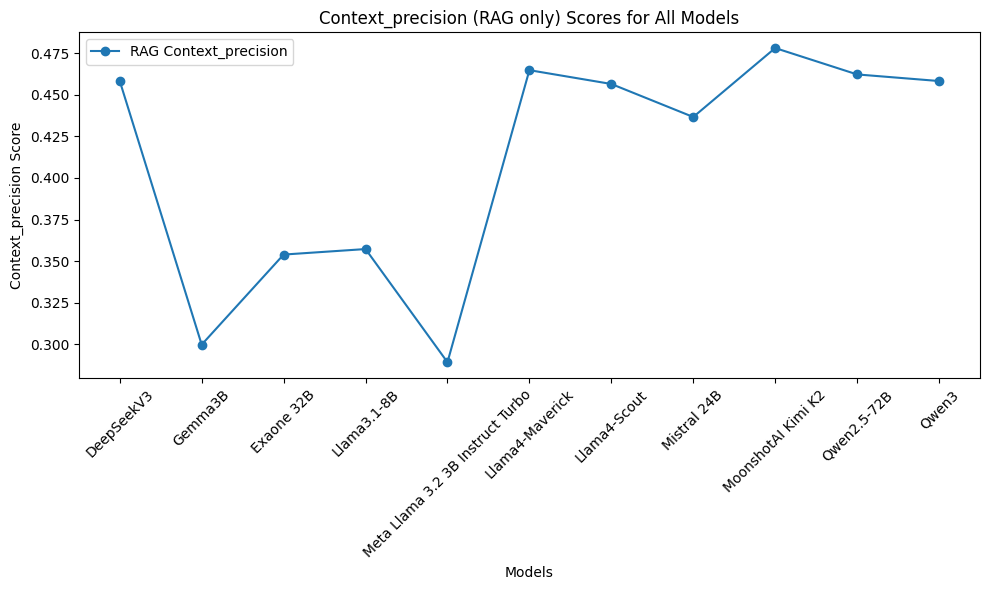

In [39]:
plot_rag_metric_all_models("advanced_rag/results", "context_precision")

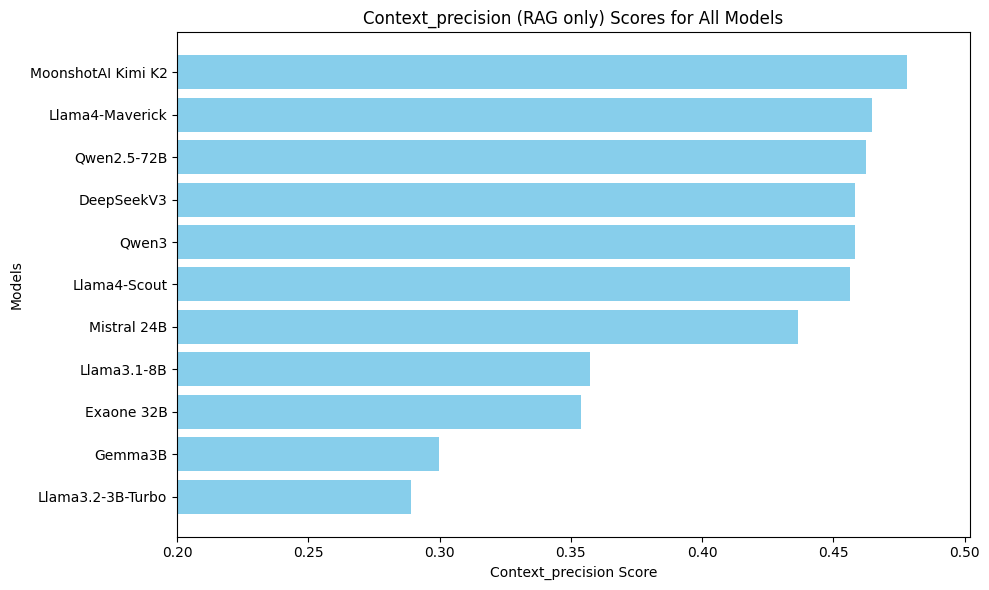

In [40]:
plot_rag_metric_all_models_barh("advanced_rag/results", "context_precision", xlim_left=0.2)

In [66]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_answer_similarity_distribution_facet(folder_path, category=None):
    dfs = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            model_name = filename.replace('.json', '')
            if category is not None:
                df = df[df['psychiatric_category'] == category]
            df = df[['Answer Semantic Similarity for vanilla', 'Answer Semantic Similarity for rag']].copy()
            df['Model'] = model_name
            dfs.append(df)
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    if not dfs:
        print("No data found.")
        return

    all_df = pd.concat(dfs, ignore_index=True)
    all_df = all_df.melt(id_vars='Model', 
                         value_vars=['Answer Semantic Similarity for vanilla', 'Answer Semantic Similarity for rag'],
                         var_name='Type', value_name='Similarity')
    all_df['Type'] = all_df['Type'].map({
        'Answer Semantic Similarity for vanilla': 'Vanilla',
        'Answer Semantic Similarity for rag': 'RAG'
    })

    # Remove NaNs
    all_df = all_df.dropna(subset=['Similarity'])

    # Short model names
    short_names = {
        "DeepSeek V3": "DeepSeekV3",
        "Google Gemma 3n E4B-it": "Gemma3B",
        "LG AI ExaOne 3.5 32B Instruct": "Exaone 32B",
        "Meta Llama 3.1 8B Instruct Turbo": "Llama3.1-8B",
        "Meta Llama 4 Maverick 17B-128E-Instruct-FP8": "Llama4-Maverick",
        "Meta Llama 4 Scout 17B-16E Instruct": "Llama4-Scout",
        "Mistral Small 24B Instruct-2501": "Mistral 24B",
        "Qwen 2.5-72B-Instruct-Turbo": "Qwen2.5-72B",
        "Qwen3 235B-A22B-fp8": "Qwen3",
        "Meta Llama 3.2 3B Instruct Turbo": "Llama3.2-3B-Turbo",
    }
    all_df['Short Model'] = all_df['Model'].map(lambda x: short_names.get(x, x))

    # Suppose 'Similarity' is your column with scores in [0, 1]
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']
    all_df['Similarity_bin'] = pd.cut(all_df['Similarity'], bins=bins, labels=labels, include_lowest=True)



    

    # FacetGrid barplot (histogram or boxplot)
    g = sns.FacetGrid(all_df, col="Short Model", col_wrap=4, sharex=True, sharey=True, height=4)
    g.map_dataframe(sns.histplot, x="Similarity", hue="Type", element="step", stat="count", common_norm=False, bins=15, alpha=0.6)
    g.add_legend()
    g.set_titles("{col_name}")
    plt.subplots_adjust(top=0.85)
    title = "Distribution of Answer Similarity Scores by Model"
    if category:
        title += f" ({category})"
    g.figure.suptitle(title)
    plt.show()

In [44]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def plot_answer_similarity_distribution_facet(folder_path, category=None):
    dfs = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            model_name = filename.replace('.json', '')
            if category is not None:
                df = df[df['psychiatric_category'] == category]
            # Keep only needed columns
            df = df[['Answer Semantic Similarity for rag', 'RAG Rubric Score']].copy()
            df['Model'] = model_name
            dfs.append(df)
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    if not dfs:
        print("No data found.")
        return

    all_df = pd.concat(dfs, ignore_index=True)
    
    # Remove NaNs
    all_df = all_df.dropna(subset=['Answer Semantic Similarity for rag', 'RAG Rubric Score'])

    # Create bins based on RAG similarity values
    bins = [0, 0.2, 0.4, 0.6, 0.8, 0.85, 0.9 , 0.95, 1.0]
    labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-0.85', '0.85-0.9', '0.9-0.95', '0.95-1.0']
    all_df['RAG_Similarity_bin'] = pd.cut(all_df['Answer Semantic Similarity for rag'], 
                                          bins=bins, labels=labels, include_lowest=True)

    # Prepare data for clustering
    df_cluster = all_df.dropna(subset=['RAG_Similarity_bin', 'RAG Rubric Score']).copy()
    df_cluster['RAG_Similarity_bin_num'] = df_cluster['RAG_Similarity_bin'].cat.codes  # Convert bin to numeric

    # Features for clustering: RAG similarity bin (numeric) and RAG rubric score
    X = df_cluster[['RAG_Similarity_bin_num', 'RAG Rubric Score']].astype(float)

    # Run KMeans clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    df_cluster['Cluster'] = kmeans.fit_predict(X)

    cluster_summary = df_cluster.groupby('Cluster').agg({
        'RAG Rubric Score': ['mean', 'count'],
        'RAG_Similarity_bin_num': 'mean',
        'RAG_Similarity_bin': lambda x: x.mode().iloc[0] if not x.mode().empty else 'N/A'
    }).round(2)

    cluster_summary.columns = ['Avg_Rubric', 'Count', 'Avg_Similarity_Bin', 'Most_Common_Sim_Bin']
    cluster_summary = cluster_summary.reset_index()
    
    # Create labels with performance info
    labels = []
    colors = []
    for _, row in cluster_summary.iterrows():
        cluster_id = int(row['Cluster'])
        if row['Avg_Rubric'] >= 4.0:
            performance = "High Perf"
            color = 'green'
        elif row['Avg_Rubric'] >= 3.0:
            performance = "Moderate Perf"
            color = 'orange'
        else:
            performance = "Low Perf"
            color = 'red'
            
        label = (
            f"Cluster {cluster_id}\n"
            f"{performance}\n"
            f"{int(row['Count'])} cases\n"
            f"Rubric: {row['Avg_Rubric']:.2f}\n"
            f"Sim: {row['Most_Common_Sim_Bin']}"
        )
        labels.append(label)
        colors.append(color)
    
    # Create treemap
    plt.figure(figsize=(12, 8))
    squarify.plot(sizes=cluster_summary['Count'], 
                  label=labels, 
                  color=colors,
                  alpha=0.7, 
                  pad=True)
    plt.axis('off')
    plt.title('RAG Performance Clusters - Treemap Visualization\n(Size = Number of Cases)', fontsize=16)
    plt.show()
    
    return cluster_summary


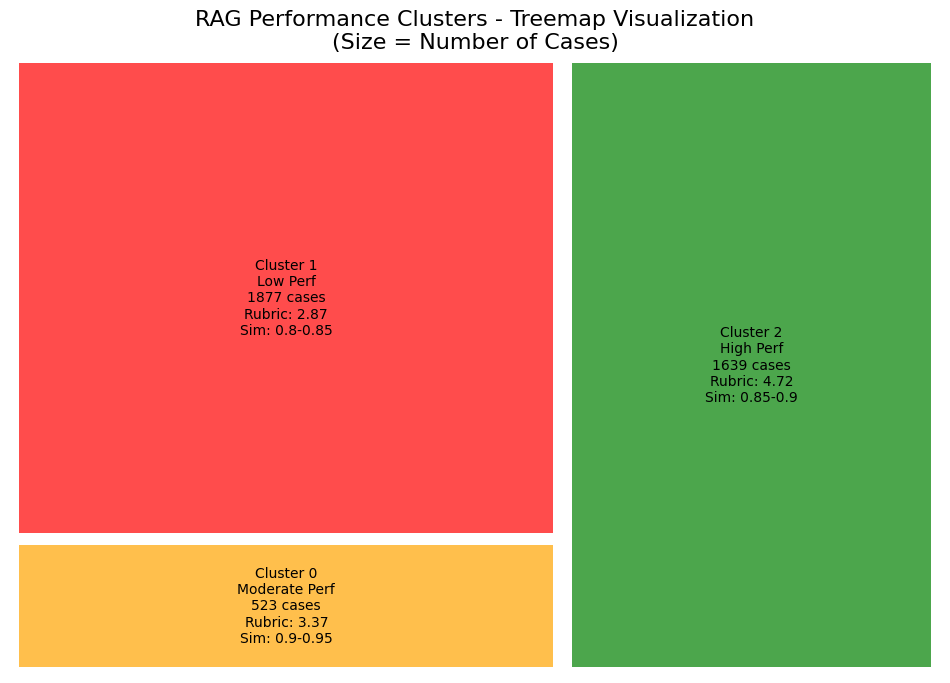

,Cluster,Avg_Rubric,Count,Avg_Similarity_Bin,Most_Common_Sim_Bin
0,0,3.37,523,6.03,0.9-0.95
1,1,2.87,1877,4.12,0.8-0.85
2,2,4.72,1639,5.21,0.85-0.9


In [45]:
plot_answer_similarity_distribution_facet("advanced_rag/results")

'0-0.2' → 0
'0.2-0.4' → 1
'0.4-0.6' → 2
'0.6-0.8' → 3
'0.8-0.85' → 4
'0.85-0.9' → 5
'0.9-0.95' → 6
'0.95-1.0' → 7

Cluster 0 - shitty ribric, shitty similarity.
Cluster 2 high rubric, high similarity.

Cluster 3 - high similarity, but bad rubric

Cluster 4 - normal rubric, mid similarity. 

In [46]:
def plot_answer_similarity_distribution_facet_vanilla(folder_path, category=None):
    dfs = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            model_name = filename.replace('.json', '')
            if category is not None:
                df = df[df['psychiatric_category'] == category]
            # Keep only needed columns
            df = df[['Answer Semantic Similarity for vanilla', 'Vanilla Rubric Score']].copy()
            df['Model'] = model_name
            dfs.append(df)
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    if not dfs:
        print("No data found.")
        return

    all_df = pd.concat(dfs, ignore_index=True)
    
    # Remove NaNs
    all_df = all_df.dropna(subset=['Answer Semantic Similarity for vanilla', 'Vanilla Rubric Score'])

    # Create bins based on Vanilla similarity values
    bins = [0, 0.2, 0.4, 0.6, 0.8, 0.85, 0.9 , 0.95, 1.0]
    labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-0.85', '0.85-0.9', '0.9-0.95', '0.95-1.0']
    all_df['Vanilla_Similarity_bin'] = pd.cut(all_df['Answer Semantic Similarity for vanilla'], 
                                              bins=bins, labels=labels, include_lowest=True)

    # Prepare data for clustering
    df_cluster = all_df.dropna(subset=['Vanilla_Similarity_bin', 'Vanilla Rubric Score']).copy()
    df_cluster['Vanilla_Similarity_bin_num'] = df_cluster['Vanilla_Similarity_bin'].cat.codes  # Convert bin to numeric

    # Features for clustering: Vanilla similarity bin (numeric) and Vanilla rubric score
    X = df_cluster[['Vanilla_Similarity_bin_num', 'Vanilla Rubric Score']].astype(float)

    # Run KMeans clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    df_cluster['Cluster'] = kmeans.fit_predict(X)

    cluster_summary = df_cluster.groupby('Cluster').agg({
        'Vanilla Rubric Score': ['mean', 'count'],
        'Vanilla_Similarity_bin_num': 'mean',
        'Vanilla_Similarity_bin': lambda x: x.mode().iloc[0] if not x.mode().empty else 'N/A'
    }).round(2)

    cluster_summary.columns = ['Avg_Rubric', 'Count', 'Avg_Similarity_Bin', 'Most_Common_Sim_Bin']
    cluster_summary = cluster_summary.reset_index()
    
    # Create labels with performance info
    labels = []
    colors = []
    for _, row in cluster_summary.iterrows():
        cluster_id = int(row['Cluster'])
        if row['Avg_Rubric'] >= 4.0:
            performance = "High Perf"
            color = 'green'
        elif row['Avg_Rubric'] >= 3.0:
            performance = "Moderate Perf"
            color = 'orange'
        else:
            performance = "Low Perf"
            color = 'red'
            
        label = (
            f"Cluster {cluster_id}\n"
            f"{performance}\n"
            f"{int(row['Count'])} cases\n"
            f"Rubric: {row['Avg_Rubric']:.2f}\n"
            f"Sim: {row['Most_Common_Sim_Bin']}"
        )
        labels.append(label)
        colors.append(color)
    
    # Create treemap
    plt.figure(figsize=(12, 8))
    squarify.plot(sizes=cluster_summary['Count'], 
                  label=labels, 
                  color=colors,
                  alpha=0.7, 
                  pad=True)
    plt.axis('off')
    plt.title('Vanilla Performance Clusters - Treemap Visualization\n(Size = Number of Cases)', fontsize=16)
    plt.show()
    
    return cluster_summary

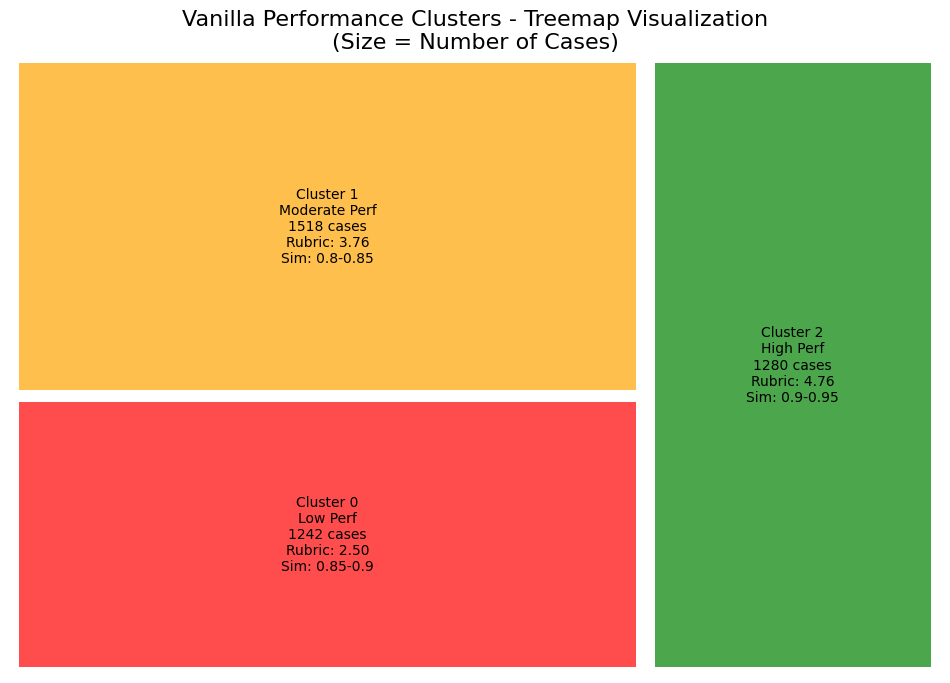

,Cluster,Avg_Rubric,Count,Avg_Similarity_Bin,Most_Common_Sim_Bin
0,0,2.50,1242,5.16,0.85-0.9
1,1,3.76,1518,4.07,0.8-0.85
2,2,4.76,1280,5.69,0.9-0.95


In [47]:
plot_answer_similarity_distribution_facet_vanilla("advanced_rag/results")

In [48]:
def plot_answer_similarity_distribution_facet_combined(folder_path, category=None, n_clusters=3, csv_path='similarity_clusters_combined.csv'):
    import os
    import json
    import pandas as pd
    import matplotlib.pyplot as plt
    import squarify
    from sklearn.cluster import KMeans

    dfs = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            model_name = filename.replace('.json', '')
            if category is not None:
                df = df[df['psychiatric_category'] == category]
            # Keep only needed columns
            df = df[['Modified Questions', 'Reasonings', 'Generated Vanilla Answer', 'Generated RAG Answer', 'Top k Similarity', 'Retrieved Context',
                     'Answer Semantic Similarity for rag', 'RAG Rubric Score',
                     'Answer Semantic Similarity for vanilla', 'Vanilla Rubric Score']].copy()
            df['Model'] = model_name
            dfs.append(df)
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    if not dfs:
        print("No data found.")
        return

    all_df = pd.concat(dfs, ignore_index=True)
    # Remove NaNs for both
    all_df = all_df.dropna(subset=[
        'Answer Semantic Similarity for rag', 'RAG Rubric Score',
        'Answer Semantic Similarity for vanilla', 'Vanilla Rubric Score'
    ])

    # Binning
    bins = [0, 0.2, 0.4, 0.6, 0.8, 0.85, 0.9, 0.95, 1.0]
    labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-0.85', '0.85-0.9', '0.9-0.95', '0.95-1.0']
    all_df['RAG_Similarity_bin'] = pd.cut(all_df['Answer Semantic Similarity for rag'], bins=bins, labels=labels, include_lowest=True)
    all_df['Vanilla_Similarity_bin'] = pd.cut(all_df['Answer Semantic Similarity for vanilla'], bins=bins, labels=labels, include_lowest=True)

    # RAG clustering
    df_rag = all_df.dropna(subset=['RAG_Similarity_bin', 'RAG Rubric Score']).copy()
    df_rag['RAG_Similarity_bin_num'] = df_rag['RAG_Similarity_bin'].cat.codes
    X_rag = df_rag[['RAG_Similarity_bin_num', 'RAG Rubric Score']].astype(float)
    kmeans_rag = KMeans(n_clusters=n_clusters, random_state=42)
    rag_clusters = kmeans_rag.fit_predict(X_rag)
    all_df.loc[df_rag.index, 'RAG_Cluster'] = rag_clusters

    # Vanilla clustering
    df_van = all_df.dropna(subset=['Vanilla_Similarity_bin', 'Vanilla Rubric Score']).copy()
    df_van['Vanilla_Similarity_bin_num'] = df_van['Vanilla_Similarity_bin'].cat.codes
    X_van = df_van[['Vanilla_Similarity_bin_num', 'Vanilla Rubric Score']].astype(float)
    kmeans_van = KMeans(n_clusters=n_clusters, random_state=42)
    van_clusters = kmeans_van.fit_predict(X_van)
    all_df.loc[df_van.index, 'Vanilla_Cluster'] = van_clusters

    # Save to CSV
    all_df.to_csv(csv_path, index=False)

    # RAG cluster summary and treemap
    rag_summary = df_rag.copy()
    rag_summary['Cluster'] = rag_clusters
    rag_cluster_summary = rag_summary.groupby('Cluster').agg({
        'RAG Rubric Score': ['mean', 'count'],
        'RAG_Similarity_bin_num': 'mean',
        'RAG_Similarity_bin': lambda x: x.mode().iloc[0] if not x.mode().empty else 'N/A'
    }).round(2)
    rag_cluster_summary.columns = ['Avg_Rubric', 'Count', 'Avg_Similarity_Bin', 'Most_Common_Sim_Bin']
    rag_cluster_summary = rag_cluster_summary.reset_index()

    rag_labels, rag_colors = [], []
    for _, row in rag_cluster_summary.iterrows():
        cluster_id = int(row['Cluster'])
        if row['Avg_Rubric'] >= 4.0:
            performance = "High Perf"
            color = 'green'
        elif row['Avg_Rubric'] >= 3.0:
            performance = "Moderate Perf"
            color = 'orange'
        else:
            performance = "Low Perf"
            color = 'red'
        label = (
            f"Cluster {cluster_id}\n"
            f"{performance}\n"
            f"{int(row['Count'])} cases\n"
            f"Rubric: {row['Avg_Rubric']:.2f}\n"
            f"Sim: {row['Most_Common_Sim_Bin']}"
        )
        rag_labels.append(label)
        rag_colors.append(color)

    plt.figure(figsize=(12, 8))
    squarify.plot(sizes=rag_cluster_summary['Count'], label=rag_labels, color=rag_colors, alpha=0.7, pad=True)
    plt.axis('off')
    plt.title('RAG Performance Clusters - Treemap Visualization\n(Size = Number of Cases)', fontsize=16)
    plt.show()

    # Vanilla cluster summary and treemap
    van_summary = df_van.copy()
    van_summary['Cluster'] = van_clusters
    van_cluster_summary = van_summary.groupby('Cluster').agg({
        'Vanilla Rubric Score': ['mean', 'count'],
        'Vanilla_Similarity_bin_num': 'mean',
        'Vanilla_Similarity_bin': lambda x: x.mode().iloc[0] if not x.mode().empty else 'N/A'
    }).round(2)
    van_cluster_summary.columns = ['Avg_Rubric', 'Count', 'Avg_Similarity_Bin', 'Most_Common_Sim_Bin']
    van_cluster_summary = van_cluster_summary.reset_index()

    van_labels, van_colors = [], []
    for _, row in van_cluster_summary.iterrows():
        cluster_id = int(row['Cluster'])
        if row['Avg_Rubric'] >= 4.0:
            performance = "High Perf"
            color = 'green'
        elif row['Avg_Rubric'] >= 3.0:
            performance = "Moderate Perf"
            color = 'orange'
        else:
            performance = "Low Perf"
            color = 'red'
        label = (
            f"Cluster {cluster_id}\n"
            f"{performance}\n"
            f"{int(row['Count'])} cases\n"
            f"Rubric: {row['Avg_Rubric']:.2f}\n"
            f"Sim: {row['Most_Common_Sim_Bin']}"
        )
        van_labels.append(label)
        van_colors.append(color)

    plt.figure(figsize=(12, 8))
    squarify.plot(sizes=van_cluster_summary['Count'], label=van_labels, color=van_colors, alpha=0.7, pad=True)
    plt.axis('off')
    plt.title('Vanilla Performance Clusters - Treemap Visualization\n(Size = Number of Cases)', fontsize=16)
    plt.show()

    return rag_cluster_summary, van_cluster_summary

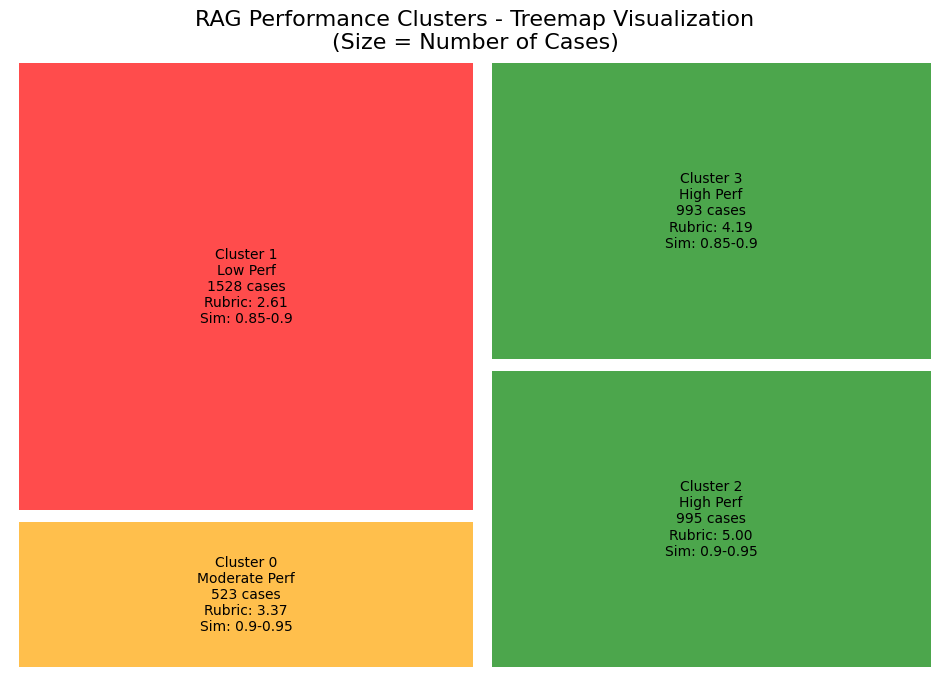

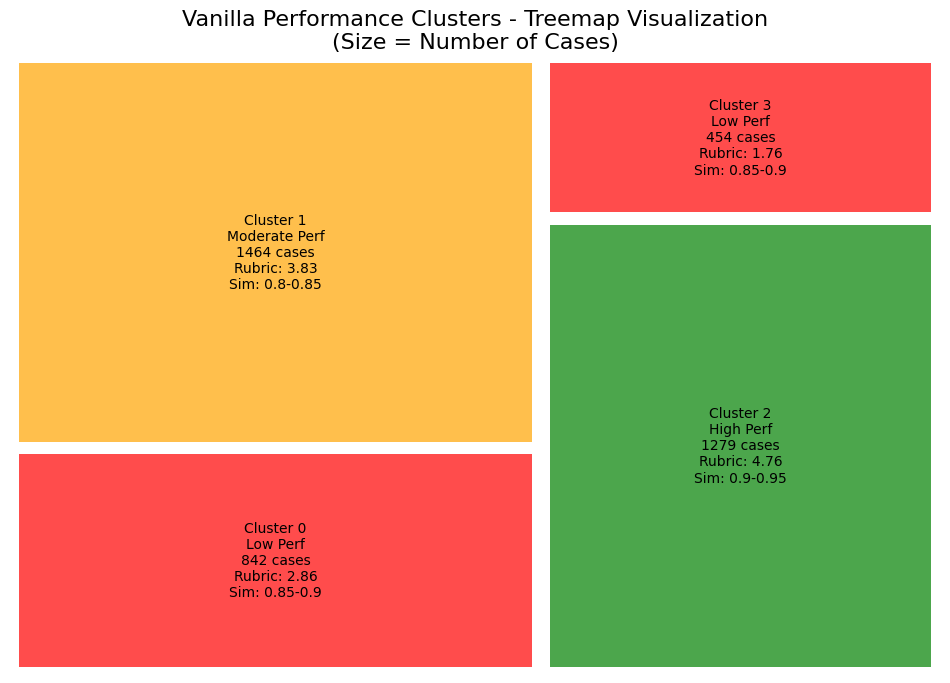

(   Cluster  Avg_Rubric  Count  Avg_Similarity_Bin Most_Common_Sim_Bin
 0        0        3.37    523                6.03            0.9-0.95
 1        1        2.61   1528                4.21            0.85-0.9
 2        2        5.00    995                5.59            0.9-0.95
 3        3        4.19    993                4.31            0.85-0.9,
    Cluster  Avg_Rubric  Count  Avg_Similarity_Bin Most_Common_Sim_Bin
 0        0        2.86    842                5.45            0.85-0.9
 1        1        3.83   1464                4.11            0.8-0.85
 2        2        4.76   1279                5.69            0.9-0.95
 3        3        1.76    454                4.35            0.85-0.9)

In [64]:
plot_answer_similarity_distribution_facet_combined("advanced_rag/results", n_clusters=4, csv_path='similarity_clusters_combined.csv')

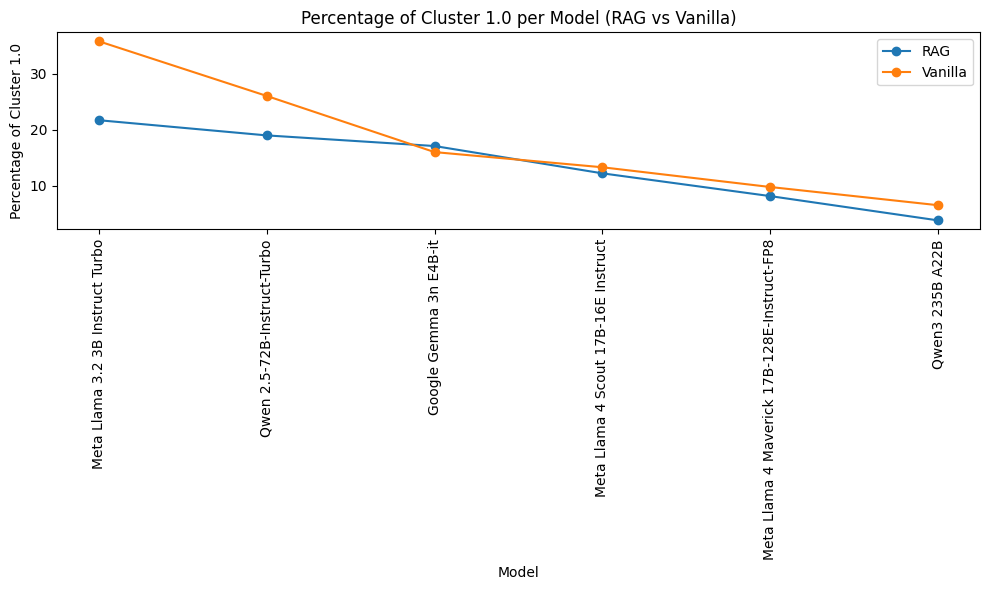

In [62]:
# Prepare a function to get cluster 1.0 percentages for a given cluster column

df = pd.read_csv("similarity_clusters_combined.csv")

def get_cluster1_percent(df, cluster_col, cluster_num=1.0):
    cluster_counts = df.groupby(['Model', cluster_col]).size().reset_index(name='Count')
    total_counts = cluster_counts.groupby('Model')['Count'].transform('sum')
    cluster_counts['Percent'] = cluster_counts['Count'] / total_counts * 100
    # Only keep cluster 1.0
    cluster1 = cluster_counts[cluster_counts[cluster_col] == cluster_num][['Model', 'Percent']]
    cluster1 = cluster1.set_index('Model')
    return cluster1

# Get cluster 1.0 percentages for RAG and Vanilla
rag_1 = get_cluster1_percent(df, 'RAG_Cluster', cluster_num=4.0).rename(columns={'Percent': 'RAG'})
van_1 = get_cluster1_percent(df, 'Vanilla_Cluster', cluster_num=3.0).rename(columns={'Percent': 'Vanilla'})

# Combine into one DataFrame
combined = pd.concat([rag_1, van_1], axis=1).fillna(0)

# Optional: sort by RAG or Vanilla
combined = combined.sort_values('RAG', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(combined.index, combined['RAG'], marker='o', label='RAG')
plt.plot(combined.index, combined['Vanilla'], marker='o', label='Vanilla')
plt.ylabel('Percentage of Cluster 1.0')
plt.xlabel('Model')
plt.title('Percentage of Cluster 1.0 per Model (RAG vs Vanilla)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [63]:
def create_cluster_percentage_table(df):
    """
    Create a table showing percentage of specific clusters and remaining clusters for each model.
    
    Args:
        df: DataFrame with cluster data (should have 'Model', 'RAG_Cluster', 'Vanilla_Cluster' columns)
    
    Returns:
        DataFrame with cluster percentages by model
    """
    results = []
    
    # Get unique models
    models = df['Model'].unique()
    
    for model in models:
        model_data = df[df['Model'] == model]
        
        # RAG cluster analysis
        rag_total = model_data['RAG_Cluster'].notna().sum()
        rag_cluster_4_count = (model_data['RAG_Cluster'] == 4.0).sum()
        rag_cluster_4_pct = (rag_cluster_4_count / rag_total * 100) if rag_total > 0 else 0
        rag_other_pct = 100 - rag_cluster_4_pct if rag_total > 0 else 0
        
        # Vanilla cluster analysis
        vanilla_total = model_data['Vanilla_Cluster'].notna().sum()
        vanilla_cluster_3_count = (model_data['Vanilla_Cluster'] == 3.0).sum()
        vanilla_cluster_3_pct = (vanilla_cluster_3_count / vanilla_total * 100) if vanilla_total > 0 else 0
        vanilla_other_pct = 100 - vanilla_cluster_3_pct if vanilla_total > 0 else 0
        
        results.append({
            'Model': model,
            'RAG Cluster 4 (%)': f"{rag_cluster_4_pct:.1f}",
            'RAG Other Clusters (%)': f"{rag_other_pct:.1f}",
            'Vanilla Cluster 3 (%)': f"{vanilla_cluster_3_pct:.1f}",
            'Vanilla Other Clusters (%)': f"{vanilla_other_pct:.1f}",
            'RAG Total Cases': rag_total,
            'Vanilla Total Cases': vanilla_total
        })
    
    # Create DataFrame and sort by RAG Cluster 4 percentage
    results_df = pd.DataFrame(results)
    results_df['RAG Cluster 4 (%) Numeric'] = results_df['RAG Cluster 4 (%)'].astype(float)
    results_df = results_df.sort_values('RAG Cluster 4 (%) Numeric', ascending=False)
    results_df = results_df.drop('RAG Cluster 4 (%) Numeric', axis=1)
    
    # Apply short names for better display
    short_names = {
        "DeepSeek V3": "DeepSeekV3",
        "Google Gemma 3n E4B-it": "Gemma3B",
        "LG AI ExaOne 3.5 32B Instruct": "Exaone 32B",
        "Meta Llama 3.1 8B Instruct Turbo": "Llama3.1-8B",
        "Meta Llama 4 Maverick 17B-128E-Instruct-FP8": "Llama4-Maverick",
        "Meta Llama 4 Scout 17B-16E Instruct": "Llama4-Scout",
        "Mistral Small 24B Instruct-2501": "Mistral 24B",
        "Qwen 2.5-72B-Instruct-Turbo": "Qwen2.5-72B",
        "Qwen3 235B-A22B-fp8": "Qwen3",
        "Meta Llama 3.2 3B Instruct Turbo": "Llama3.2-3B-Turbo",
    }
    
    results_df['Model'] = results_df['Model'].map(lambda x: short_names.get(x, x))
    
    print("Cluster Distribution by Model")
    print("=" * 80)
    print("RAG Cluster 4: High performance cluster")
    print("Vanilla Cluster 3: High performance cluster") 
    print("Other Clusters: All remaining clusters combined")
    print("=" * 80)
    
    # Display without total cases for cleaner output
    display_df = results_df.drop(['RAG Total Cases', 'Vanilla Total Cases'], axis=1)
    display(display_df.reset_index(drop=True))
    
    return results_df

# Usage with your existing data
# Assuming df is loaded from the CSV file created by plot_answer_similarity_distribution_facet_combined
df = pd.read_csv('similarity_clusters_combined.csv')
cluster_table = create_cluster_percentage_table(df)

Cluster Distribution by Model
RAG Cluster 4: High performance cluster
Vanilla Cluster 3: High performance cluster
Other Clusters: All remaining clusters combined


,Model,RAG Cluster 4 (%),RAG Other Clusters (%),Vanilla Cluster 3 (%),Vanilla Other Clusters (%)
0,Llama3.2-3B-Turbo,21.7,78.3,35.8,64.2
1,Qwen2.5-72B,19.0,81.0,26.0,74.0
2,Gemma3B,17.1,82.9,16.0,84.0
3,Llama4-Scout,12.2,87.8,13.3,86.7
4,Llama4-Maverick,8.1,91.9,9.8,90.2
5,Qwen3 235B A22B,3.8,96.2,6.5,93.5


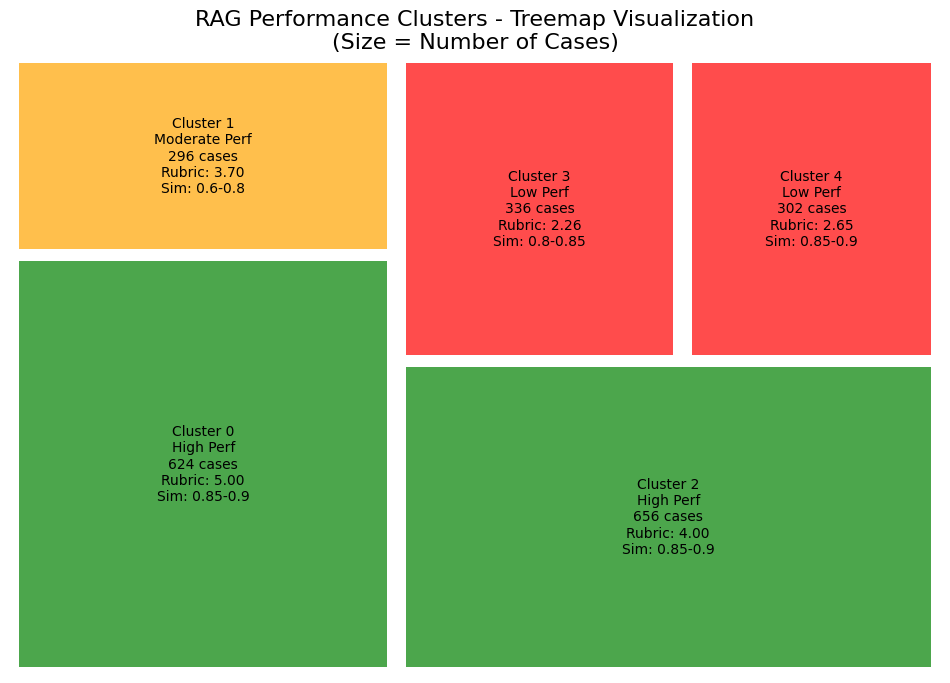

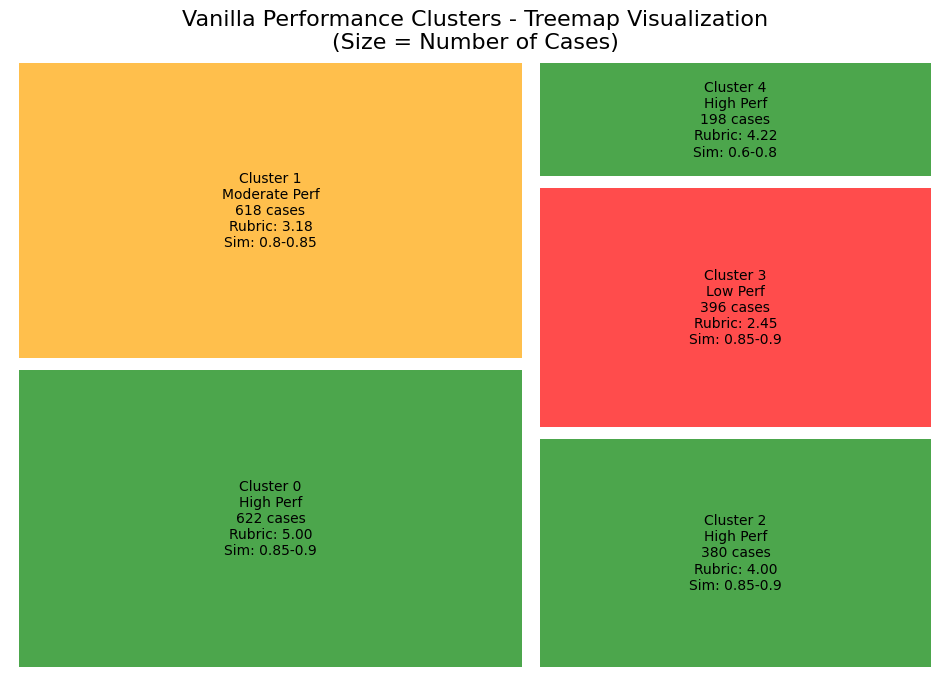

(   Cluster  Avg_Rubric  Count  Avg_Similarity_Bin Most_Common_Sim_Bin
 0        0        5.00    624                5.08            0.85-0.9
 1        1        3.70    296                2.99             0.6-0.8
 2        2        4.00    656                4.72            0.85-0.9
 3        3        2.26    336                3.66            0.8-0.85
 4        4        2.65    302                5.20            0.85-0.9,
    Cluster  Avg_Rubric  Count  Avg_Similarity_Bin Most_Common_Sim_Bin
 0        0        5.00    622                5.00            0.85-0.9
 1        1        3.18    618                3.73            0.8-0.85
 2        2        4.00    380                5.23            0.85-0.9
 3        3        2.45    396                5.20            0.85-0.9
 4        4        4.22    198                2.95             0.6-0.8)

In [52]:
plot_answer_similarity_distribution_facet_combined("naive_rag/results", n_clusters=5, csv_path='similarity_clusters_combined.csv')

In [53]:
# Usage with your existing data
# Assuming df is loaded from the CSV file created by plot_answer_similarity_distribution_facet_combined
df = pd.read_csv('similarity_clusters_combined.csv')
cluster_table = create_cluster_percentage_table(df)

Cluster Distribution by Model
RAG Cluster 4: High performance cluster
Vanilla Cluster 3: High performance cluster
Other Clusters: All remaining clusters combined


,Model,RAG Cluster 4 (%),RAG Other Clusters (%),Vanilla Cluster 3 (%),Vanilla Other Clusters (%)
0,Llama3.2-3B-Turbo,21.7,78.3,35.8,64.2
1,Qwen2.5-72B,19.0,81.0,26.0,74.0
2,Gemma3B,17.1,82.9,16.0,84.0
3,Llama4-Scout,12.2,87.8,13.3,86.7
4,Llama4-Maverick,8.1,91.9,9.8,90.2
5,Qwen3 235B A22B,3.8,96.2,6.5,93.5


In [54]:
def print_rag_cluster_examples(df, cluster_num=4.0, n=3, wrap_width=80):
    """
    Print n examples from a specific RAG_Cluster, showing question, RAG answer, vanilla answer, reasoning, retrieved context, and all metrics.

    Args:
        df (pd.DataFrame): DataFrame containing relevant columns.
        cluster_num (float): Cluster number to filter (default 4.0 for high perf).
        n (int): Number of examples to print.
        wrap_width (int): Width for text wrapping.
    """
    import textwrap

    # Filter for the specified cluster
    df_cluster = df[df['RAG_Cluster'] == cluster_num]

    # Sample n rows
    sample = df_cluster.sample(n=min(n, len(df_cluster)), random_state=42)

    def wrap(text):
        return "\n".join(textwrap.wrap(str(text), width=wrap_width))

    metric_cols = [
        'Answer Semantic Similarity for rag',
        'Answer Semantic Similarity for vanilla',
        'RAG Rubric Score',
        'Vanilla Rubric Score',
        'faithfulness for RAG run 1',
        'faithfulness for RAG run 2',
        'faithfulness for RAG run 3',
        'context_precision for RAG run 1',
        'context_precision for RAG run 2',
        'context_precision for RAG run 3',
        'context_recall for RAG run 1',
        'context_recall for RAG run 2',
        'context_recall for RAG run 3',
        'answer_relevancy for Vanilla run 1',
        'answer_relevancy for Vanilla run 2',
        'answer_relevancy for Vanilla run 3',
        'answer_relevancy for RAG run 1',
        'answer_relevancy for RAG run 2',
        'answer_relevancy for RAG run 3'
    ]

    for i, row in sample.iterrows():
        print("=" * 60)
        print("Question:\n" + wrap(row.get('Modified Questions', '[No question]')))
        print("\nRAG Answer:\n" + wrap(row.get('Generated RAG Answer', '[No answer]')))
        print("\nVanilla Answer:\n" + wrap(row.get('Generated Vanilla Answer', '[No vanilla answer]')))
        print("\nReasoning:\n" + wrap(row.get('Reasonings', '[No reasoning]')))
        print("\nRetrieved Context:\n" + wrap(row.get('Retrieved Context', '[No context]')))
        print("\nMetrics:")
        for col in metric_cols:
            if col in row:
                print(f"  {col}: {row.get(col, 'N/A')}")
        print()

In [55]:
print_rag_cluster_examples(df, cluster_num=4.0, n=6)

Question:
A study is conducted to investigate the relationship between the development of
type 2 diabetes mellitus and the use of atypical antipsychotic medications in
patients with schizophrenia. 300 patients who received the atypical
antipsychotic clozapine and 300 patients who received the typical antipsychotic
haloperidol in long-acting injectable form were followed for 2 years. At the end
of the observation period, the incidence of type 2 diabetes mellitus was
compared between the two groups. Receipt of clozapine was found to be associated
with an increased risk of diabetes mellitus relative to haloperidol (RR = 1.43,
95% p<0.01). Based on these results, what proportion of patients receiving
clozapine would not have been diagnosed with type 2 diabetes mellitus if they
had been taking a typical antipsychotic?

RAG Answer:
To determine the proportion of patients receiving clozapine who would not have
been diagnosed with type 2 diabetes mellitus if they had been taking a typical
anti

In [56]:
def print_vanilla_cluster_examples(df, cluster_num=4.0, n=3, wrap_width=80):
    """
    Print n examples from a specific RAG_Cluster, showing question, RAG answer, vanilla answer, reasoning, retrieved context, and all metrics.

    Args:
        df (pd.DataFrame): DataFrame containing relevant columns.
        cluster_num (float): Cluster number to filter (default 4.0 for high perf).
        n (int): Number of examples to print.
        wrap_width (int): Width for text wrapping.
    """
    import textwrap

    # Filter for the specified cluster
    df_cluster = df[df['Vanilla_Cluster'] == cluster_num]

    # Sample n rows
    sample = df_cluster.sample(n=min(n, len(df_cluster)), random_state=42)

    def wrap(text):
        return "\n".join(textwrap.wrap(str(text), width=wrap_width))

    metric_cols = [
        'Answer Semantic Similarity for rag',
        'Answer Semantic Similarity for vanilla',
        'RAG Rubric Score',
        'Vanilla Rubric Score',
        'faithfulness for RAG run 1',
        'faithfulness for RAG run 2',
        'faithfulness for RAG run 3',
        'context_precision for RAG run 1',
        'context_precision for RAG run 2',
        'context_precision for RAG run 3',
        'context_recall for RAG run 1',
        'context_recall for RAG run 2',
        'context_recall for RAG run 3',
        'answer_relevancy for Vanilla run 1',
        'answer_relevancy for Vanilla run 2',
        'answer_relevancy for Vanilla run 3',
        'answer_relevancy for RAG run 1',
        'answer_relevancy for RAG run 2',
        'answer_relevancy for RAG run 3'
    ]

    for i, row in sample.iterrows():
        print("=" * 60)
        print("Question:\n" + wrap(row.get('Modified Questions', '[No question]')))
        print("\nRAG Answer:\n" + wrap(row.get('Generated RAG Answer', '[No answer]')))
        print("\nVanilla Answer:\n" + wrap(row.get('Generated Vanilla Answer', '[No vanilla answer]')))
        print("\nReasoning:\n" + wrap(row.get('Reasonings', '[No reasoning]')))
        print("\nRetrieved Context:\n" + wrap(row.get('Retrieved Context', '[No context]')))
        print("\nMetrics:")
        for col in metric_cols:
            if col in row:
                print(f"  {col}: {row.get(col, 'N/A')}")
        print()

In [57]:
print_vanilla_cluster_examples(df, cluster_num=3.0, n=6)

Question:
An investigator is studying a local anesthetic that activates both alpha and
beta adrenergic receptors. When given intravenously, it causes euphoria and
pupillary dilation. What is the most likely effect of this drug at the synaptic
cleft?

RAG Answer:
Based on the information provided, the local anesthetic in question appears to
be a sympathomimetic agent, which activates both alpha and beta adrenergic
receptors. The effects of this drug, such as euphoria and pupillary dilation,
suggest that it is likely to cause an increase in the release of norepinephrine
(NE) at the synaptic cleft.  The activation of alpha adrenergic receptors by
this drug would lead to vasoconstriction, increased blood pressure, and
pupillary dilation. The activation of beta adrenergic receptors would lead to
increased heart rate, cardiac output, and bronchodilation.  The increase in NE
release would also lead to an increase in the release of other
neurotransmitters, such as dopamine and serotonin, which

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_cluster_percentages_line(csv_path='similarity_clusters_combined.csv'):
    """
    Visualize the percentage of RAG cluster 4 and Vanilla cluster 3 for each model as a line plot.
    """
    df = pd.read_csv(csv_path)

    # Helper function to get cluster percentages
    def get_cluster_percent(df, cluster_col, cluster_num):
        cluster_counts = df.groupby(['Model', cluster_col]).size().reset_index(name='Count')
        total_counts = cluster_counts.groupby('Model')['Count'].transform('sum')
        cluster_counts['Percent'] = cluster_counts['Count'] / total_counts * 100
        cluster_pct = cluster_counts[cluster_counts[cluster_col] == cluster_num][['Model', 'Percent']]
        cluster_pct = cluster_pct.set_index('Model')
        return cluster_pct

    rag_pct = get_cluster_percent(df, 'RAG_Cluster', 4.0).rename(columns={'Percent': 'RAG Cluster 4 (%)'})
    vanilla_pct = get_cluster_percent(df, 'Vanilla_Cluster', 3.0).rename(columns={'Percent': 'Vanilla Cluster 3 (%)'})

    combined = pd.concat([rag_pct, vanilla_pct], axis=1).fillna(0)
    combined = combined.sort_values('RAG Cluster 4 (%)', ascending=False)

    # Optional: Short names for models
    short_names = {
        "DeepSeek V3": "DeepSeekV3",
        "Google Gemma 3n E4B-it": "Gemma3B",
        "LG AI ExaOne 3.5 32B Instruct": "Exaone 32B",
        "Meta Llama 3.1 8B Instruct Turbo": "Llama3.1-8B",
        "Meta Llama 4 Maverick 17B-128E-Instruct-FP8": "Llama4-Maverick",
        "Meta Llama 4 Scout 17B-16E Instruct": "Llama4-Scout",
        "Mistral Small 24B Instruct-2501": "Mistral 24B",
        "Qwen 2.5-72B-Instruct-Turbo": "Qwen2.5-72B",
        "Qwen3 235B-A22B-fp8": "Qwen3",
        "Meta Llama 3.2 3B Instruct Turbo": "Llama3.2-3B-Turbo",
    }
    combined['Short Model'] = combined.index.map(lambda x: short_names.get(x, x))

    plt.figure(figsize=(12, 6))
    plt.plot(combined['Short Model'], combined['RAG Cluster 4 (%)'], marker='o', label='RAG Cluster 4 (%)', color='green')
    plt.plot(combined['Short Model'], combined['Vanilla Cluster 3 (%)'], marker='o', label='Vanilla Cluster 3 (%)', color='blue')
    plt.ylabel('Percentage of Mistake Performance Cluster')
    plt.xlabel('Model')
    plt.title('Percentage of Mistake Cluster per Model (RAG vs Vanilla)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Usage:

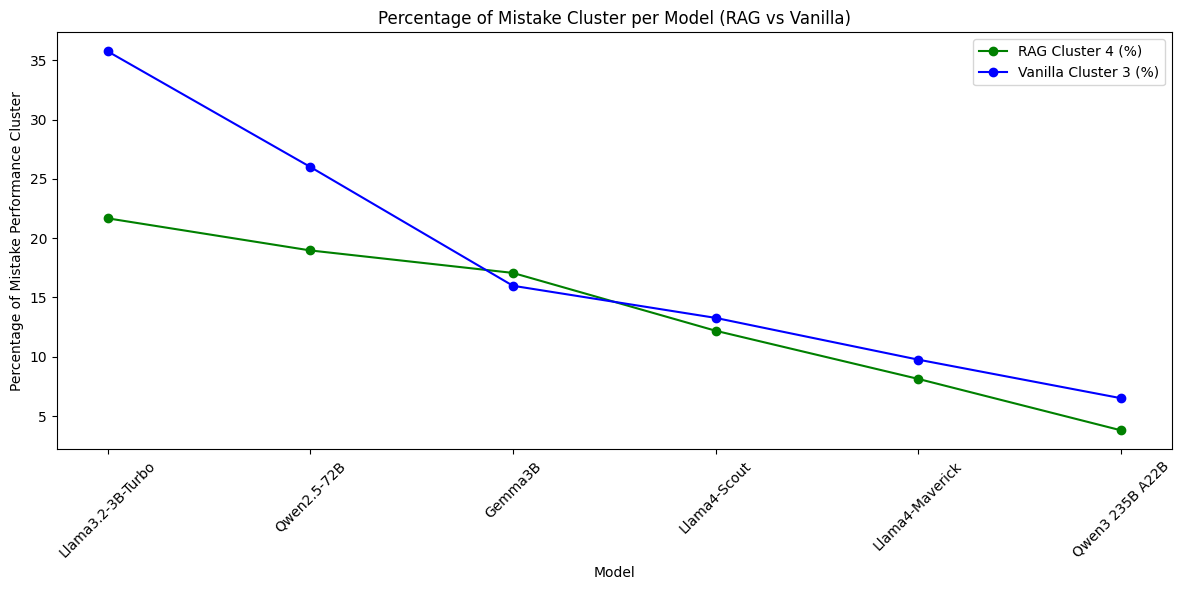

In [59]:
plot_cluster_percentages_line('similarity_clusters_combined.csv')